# COVID-19 - Clinical Data to assess diagnosis

<br>
<br>

👩‍💻 _Gabriela Oliveira da Trindade_

# >> Introduction
---

## <span style="color:blue"> Problem </span> 🎯

This is the Final Project of Alura Bootcamp - Applied Data Science. The goal here is to solve the problem 'COVID-19 - Clinical Data to assess diagnosis' presented on the Kaggle platform.

Sírio Libanes is a large Hospital in the State of São Paulo and in Brasilia that is working on the battle against COVID-19. The data and the problem were described by their Data Intelligence Team.

Here, all the problem description - Context, Call to action, Task, and Dataset -  was gotten from [Kaggle](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19).

<br>
<br>

❗ Important:
- All the data is anonymous to protect each patient's information.
- The decision on how it's organized and grouped was taken by the Sírio Libanes Team - specialists. So the data is almost prepared.
- I'm not an epidemiologist, virologist or even work on health area. I'm just exploring data, learning and practing Machine Learning and Python. So I'll not draw conclusions on that level.

### Context

COVID-19 pandemic impacted the whole world, overwhelming healthcare systems - unprepared for such intense and lengthy request for ICU beds, professionals, personal protection equipment and healthcare resources. \
Brazil recorded first COVID-19 case on February 26 and reached community transmission on March 20.

### Call to action

There is urgency in obtaining accurate that to better predict and prepare healthcare systems and avoid collapse, defined by above capacity need of ICU beds (assuming human resources, PPE and professionals are available), using individual clinical data - in lieu of epidemiological and populational data.

### Task

**Predict admission to the ICU of confirmed COVID-19 cases.** \
Based on the data available, is it feasible to predict which patients will need intensive care unit support? \
The aim is to provide tertiary and quarternary hospitals with the most accurate answer, so ICU resources can be arranged or patient transfer can be scheduled.

**Predict NOT admission to the ICU of confirmed COVID-19 cases.** \
Based on the subsample of widely available data, is it feasible to predict which patients will need intensive care unit support? \
The aim is to provide local and temporary hospitals a good enough answer, so frontline physicians can safely discharge and remotely follow up with these patients.

### Dataset

This dataset contains anonymized data from Hospital Sírio-Libanês, São Paulo and Brasilia. All data were anonymized following the best international practices and recommendations. \
Data has been cleaned and scaled by column according to Min Max Scaler to fit between -1 and 1.

**Available data:**
1. Patient demographic information (03)
2. Patient previous grouped diseases (09)
3. Blood results (36)
4. Vital signs (06)

In total there are 54 features, expanded when pertinent to the mean, median, max, min, diff and relative diff.

1. diff = max - min
2. relative diff = diff/median


## <span style="color:blue"> The notebook </span>📝

This is a Jupyter Notebook. Here you'll find Python code snippets as well as texts that allows the reader understading some conclusions, decisions and insights.

Some texts will comes with a '**>>**' signal in a different color, to highlight their purposes.

- **<span style="color: red">>></span>** This illustrate a decision taken.
- **<span style="color: yellow">>></span>** This illustrate an insight.
- **<span style="color: green">>></span>** This illustrate a conclusion.

# >> Review of project steps
---

- **As primeiras seções se dividem em: Importação das bibliotecas necessárias, obtenção dos dados e criação das funções utilizadas.**

    Essa etapa é o start do projeto, os dados são coletados no Kaggle no formato zip, lidos e convertidos em um objeto DataFrame do pandas. \
    Ao decorrer do projeto, funções são criadas e bibliotecas importadas segundo a demanda, com isso, foram separadas duas seções que agrupam todas as bibliotecas e funções utilizadas no projeto em um único espaço.


- **A próxima etapa é a de análise exploratória e preprocessamento dos dados.**
    
    Após a obtenção dos dados e leitura para um objeto dataframe, começa-se o trabalho de entendimento desses dados juntamente com a manipulação, pois a cada descoberta que demandava um ajuste nos dados, logo em seguida esse ajuste era realizado.
    
    O primeiro passo foi identificar o target, que é representado pela coluna ICU, com os valores 0 e 1.
    
    Após isso vericamos o shape dos dados, tendo-se 1925 linhas e 231 colunas. Entretanto, percebeu-se que as observações não estão organizadas apenas por paciente, mas sim pelo paciente e sua janela. O que isso significa? Cada linha representa os exames de um paciente em um dado período de tempo, por exemplo:
    
Patient | Information1 | Information2 | ... | Exame1 | Exame2 | ... | Window | ICU
:------:|:------------:|:------------:|:---:|:------:|:------:|:---:|:------:|:---:
   A    |      0       |       1      | ... |  1.2   |   1.5  | ... |   0-2  |  0
   A    |      0       |       1      | ... |  1.3   |   1.0  | ... |   2-4  |  0
   A    |      0       |       1      | ... |  1.2   |   1.1  | ... |   4-6  |  0
   A    |      0       |       1      | ... |  1.5   |   1.2  | ... |   6-12 |  0
   A    |      0       |       1      | ... |  1.5   |   1.5  | ... |Above 12|  0
  ...   |     ...      |      ...     | ... |  ...   |   ...  | ... |   ...  | ...
   Z    |      2       |       0      | ... |  1.0   |   1.6  | ... |   0-2  |  0
   Z    |      2       |       0      | ... |  1.3   |   1.0  | ... |   2-4  |  0  
   Z    |      2       |       0      | ... |  1.1   |   1.4  | ... |   4-6  |  1
   

Com isso, após refletir sobre o problema, concluiu que o uso da linha em que o paciente estava no ICU não era válida, pois não sabia se aqueles exames foram tirados quando a entrada no ICU já havia sido dado ou não. Então optou escolher uma das linhas anteriores para que o modelo fosse treinado. Para casos onde o paciente deu entrada no ICU na primeira janela, este foi desconsiderado.

Como as linhas anteriores se resumiam a não deu entrada no ICU, subiu a informação se a entrada foi dada em algum momento futuro ou não nas demais janelas. Como no exemplo acima, tem-se o resultado abaixo:

Patient | Information1 | Information2 | ... | Exame1 | Exame2 | ... | Window | ICU
:------:|:------------:|:------------:|:---:|:------:|:------:|:---:|:------:|:---:
   A    |      0       |       1      | ... |  1.2   |   1.5  | ... |   0-2  |  0
   A    |      0       |       1      | ... |  1.3   |   1.0  | ... |   2-4  |  0
   A    |      0       |       1      | ... |  NaN   |   1.1  | ... |   4-6  |  0
   A    |      0       |       1      | ... |  1.5   |   NaN  | ... |   6-12 |  0
   A    |      0       |       1      | ... |  1.5   |   1.5  | ... |Above 12|  0
  ...   |     ...      |      ...     | ... |  ...   |   ...  | ... |   ...  | ...
   Z    |      2       |       0      | ... |  1.0   |   1.6  | ... |   0-2  |  **<span style="color: red">1</span>**
   Z    |      2       |       0      | ... |  1.3   |   1.0  | ... |   2-4  |  **<span style="color: red">1</span>**  
   Z    |      2       |       0      | ... |  1.1   |   1.4  | ... |   4-6  |  1


Assim, a linha onde a entrada de fato havia sido dada foi removida. No exemplo, a linha do paciente Z, na janela 4-6, é removida, ficando a tabela abaixo:

Patient | Information1 | Information2 | ... | Exame1 | Exame2 | ... | Window | ICU
:------:|:------------:|:------------:|:---:|:------:|:------:|:---:|:------:|:---:
   A    |      0       |       1      | ... |  1.2   |   1.5  | ... |   0-2  |  0
   A    |      0       |       1      | ... |  1.3   |   1.0  | ... |   2-4  |  0
   A    |      0       |       1      | ... |  NaN   |   1.1  | ... |   4-6  |  0
   A    |      0       |       1      | ... |  1.5   |   NaN  | ... |   6-12 |  0
   A    |      0       |       1      | ... |  1.5   |   1.5  | ... |Above 12|  0
  ...   |     ...      |      ...     | ... |  ...   |   ...  | ... |   ...  | ...
   Z    |      2       |       0      | ... |  1.0   |   1.6  | ... |   0-2  |  **<span style="color: red">1</span>**
   Z    |      2       |       0      | ... |  1.3   |   1.0  | ... |   2-4  |  **<span style="color: red">1</span>**  

Após a remoção de dados que não poderiam ser utilizados, explorou os valores nulos. Uma das observações dada pelo equipe do Hospital Sírio-Libanes é que os valores de exames não se alteram muito de uma janela para outra. Logo, decidiu tratar os dados faltando com os métodos backfill e forwardfill para cada paciente.

Para aqueles pacientes que não tinham nenhum valor em algum dos exames, impossibilitando o uso do backfill ou forwardfill, optou-se por excluí-los.


escolha da janela \
análise exploratória nos dados limpos - pandas profiling \
Conversão de types em variáveis \
estudando a distribuição do target \
feature engineering \
feature selection: cenários \

# >> Summary
---

# 1. Libraries

In [142]:
from zipfile import ZipFile
from io import BytesIO
import requests
import warnings


import pandas as pd
import numpy as np
import missingno as msno
from scipy.stats import randint, uniform


import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport


from sklearn.preprocessing import OrdinalEncoder

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import plot_confusion_matrix, confusion_matrix

from sklearn.metrics import roc_auc_score, recall_score
from sklearn.metrics import roc_curve

In [2]:
# config
# pd.set_option('display.max_rows', None)

sns.set_theme(rc={'figure.figsize':(11.7,6.27)})

plt.style.use({'axes.labelsize': 16,
               'axes.titlesize': 19,
               'xtick.labelsize': 12,
               'ytick.labelsize': 12
              })

# warnings.filterwarnings('ignore')

# 2. Getting the data

In [3]:
data_url_zip = requests.get('https://github.com/gabrielatrindade/alura-bootcamp/blob/master/module5/patient.zip?raw=true')

zipfile = ZipFile(BytesIO(data_url_zip.content))
file_name= zipfile.namelist()[0]

patients = pd.read_excel(zipfile.open(file_name).read())

# 3. Functions used for cleaning and exploration

Functions that involves Machine Learning, check out the section [Machine Learning Functions](#5.1-Machine-Learning-Functions).

In [4]:
# Analysis

def create_freq_table(df: pd.DataFrame, variable: str) -> pd.DataFrame:
    
    value_count_variable = df[variable].value_counts()
    
    value_count_variable_normalized = \
        df[variable].value_counts(normalize=True)
    
    return pd.DataFrame({'count': value_count_variable,
                         'percentage': round(value_count_variable_normalized * 100, 2)})


# Cleaning

def ICU_clean(rows):
    
    # check if that patient went to UCI, if yes
    if(np.any(rows['ICU'])):
        # attribute 1 for ICU_x in all the rows
        rows['ICU_x'] = 1
    else:
        rows['ICU_x'] = 0
        
    return rows


def fill_continuous_vars(df: pd.DataFrame, method: str):
    
    continuous_features_cols = df.iloc[:, 13:-2].columns

    filled_continuous_features = (df.groupby('PATIENT_VISIT_IDENTIFIER')
                                    [continuous_features_cols]
                                    .fillna(method=method)
                                    .reset_index())

    categorical_features = df.iloc[:, :13].reset_index(drop=True)

    output = df.iloc[:, -2:].reset_index(drop=True)

    return pd.concat([categorical_features, 
                      filled_continuous_features, 
                      output], 
                     axis=1)


# Visualization

def add_labels_to_bars(ax, series: pd.Series, distance_bar: float):
    '''get a plot and a Series that represent the labels
    and then add the labels to bar tops
    distance_bar = label distance from bar top'''
    
    i=0
    for p in ax.patches:
        
        try:
            value = series.iloc[i]
            height = p.get_height() + distance_bar
        except IndexError:
            value = 0
            height = 0 + distance_bar
            
        ax.text(p.get_x()+p.get_width()/2., height,
                value, fontsize=12,
                ha="center")
        
        i += 1
        

# Feature Engineering

def add_new_features(df: pd.DataFrame):

    df["BLOODPRESSURE_ARTERIAL_MEAN"] = (df['BLOODPRESSURE_SISTOLIC_MEAN'] + 
                                         2*df['BLOODPRESSURE_DIASTOLIC_MEAN'])/3
 
    df["NEUTROPHILES/LINFOCITOS"] = df['NEUTROPHILES_MEAN']/df['LINFOCITOS_MEAN']

    df["GASO"] = df.groupby("PATIENT_VISIT_IDENTIFIER") \
                   .P02_ARTERIAL_MEAN \
                   .apply(lambda x: x.fillna(method='ffill'))
    
    df["GASO"] = (~df["GASO"].isna()).astype(int)

    return df


# Feature Selection

def sirio_libanes_feature_selection(df: pd.DataFrame):
    
    return df[["ICU",#"WINDOW",
               "PATIENT_VISIT_IDENTIFIER",
               "AGE_ABOVE65", 
               "GENDER", 
               "BLOODPRESSURE_ARTERIAL_MEAN", 
               "NEUTROPHILES/LINFOCITOS",
               "RESPIRATORY_RATE_MAX", 
               "HTN", 
               'DISEASE GROUPING 1',
               'DISEASE GROUPING 2',
               'DISEASE GROUPING 3',
               'DISEASE GROUPING 4',
               'DISEASE GROUPING 5',
               'DISEASE GROUPING 6',
               "GASO",
               "OXYGEN_SATURATION_MIN",
               "HEART_RATE_MAX",
               "PCR_MEAN",
               "CREATININ_MEAN"]]

In [5]:
# Correlation

def select_exam_vital_signs_best_corr_ICU(corr_matrix_exams: pd.DataFrame, exam: str) -> str:
    
    return (corr_matrix_exams
                [corr_matrix_exams.index.str.contains(exam)]
                .idxmax())


def X_features_with_high_correlation(data: pd.DataFrame, threshold: float) -> list:
    
    corr_matrix = \
        data.select_dtypes(exclude='int64') \
            .drop('AGE_PERCENTIL', axis=1) \
            .corr() \
            .abs()
    
    corr_matrix_shape_diagonal_null = \
        np.ones(corr_matrix.shape).astype(np.bool)
    np.fill_diagonal(corr_matrix_shape_diagonal_null, 0)
    
    corr_matrix_no_diagonal = \
        corr_matrix.where(corr_matrix_shape_diagonal_null)
    
    columns_with_high_corr = \
        [column for column in corr_matrix_no_diagonal.columns 
         if any(corr_matrix_no_diagonal[column] > threshold)]
    
    return columns_with_high_corr

# 4. Exploratory Analysis and Preprocessing data

These two steps will performed together. I'll clear the data at the same time that I'll explore it.

## Understading the data

In [6]:
patients.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1


In [7]:
patients.columns.values

array(['PATIENT_VISIT_IDENTIFIER', 'AGE_ABOVE65', 'AGE_PERCENTIL',
       'GENDER', 'DISEASE GROUPING 1', 'DISEASE GROUPING 2',
       'DISEASE GROUPING 3', 'DISEASE GROUPING 4', 'DISEASE GROUPING 5',
       'DISEASE GROUPING 6', 'HTN', 'IMMUNOCOMPROMISED', 'OTHER',
       'ALBUMIN_MEDIAN', 'ALBUMIN_MEAN', 'ALBUMIN_MIN', 'ALBUMIN_MAX',
       'ALBUMIN_DIFF', 'BE_ARTERIAL_MEDIAN', 'BE_ARTERIAL_MEAN',
       'BE_ARTERIAL_MIN', 'BE_ARTERIAL_MAX', 'BE_ARTERIAL_DIFF',
       'BE_VENOUS_MEDIAN', 'BE_VENOUS_MEAN', 'BE_VENOUS_MIN',
       'BE_VENOUS_MAX', 'BE_VENOUS_DIFF', 'BIC_ARTERIAL_MEDIAN',
       'BIC_ARTERIAL_MEAN', 'BIC_ARTERIAL_MIN', 'BIC_ARTERIAL_MAX',
       'BIC_ARTERIAL_DIFF', 'BIC_VENOUS_MEDIAN', 'BIC_VENOUS_MEAN',
       'BIC_VENOUS_MIN', 'BIC_VENOUS_MAX', 'BIC_VENOUS_DIFF',
       'BILLIRUBIN_MEDIAN', 'BILLIRUBIN_MEAN', 'BILLIRUBIN_MIN',
       'BILLIRUBIN_MAX', 'BILLIRUBIN_DIFF', 'BLAST_MEDIAN', 'BLAST_MEAN',
       'BLAST_MIN', 'BLAST_MAX', 'BLAST_DIFF', 'CALCIUM_MEDIAN',
   

### Available data [[1]](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19)

1. Patient demographic information (03)
2. Patient previous grouped diseases (09)
3. Blood results (36)
4. Vital signs (06)

In total there are 54 features, expanded when pertinent to the mean, median, max, min, diff and relative diff.

1. diff = max - min
2. relative diff = diff/median

In [8]:
mean_vars_count = 0
median_vars_count = 0
max_vars_count = 0
min_vars_count = 0
diff_vars_count = 0
relative_diff_vars_count = 0

for column in patients.columns:
    if '_MEAN' in column:
        mean_vars_count+=1
    elif '_MEDIAN' in column:
            median_vars_count+=1
    elif '_MAX' in column:
            max_vars_count+=1
    elif '_MIN' in column:
            min_vars_count+=1
    elif '_DIFF' in column[-5:]:
            diff_vars_count+=1
    elif '_DIFF_REL' in column:
            relative_diff_vars_count+=1
            
print(mean_vars_count, median_vars_count, 
      max_vars_count, min_vars_count,
      diff_vars_count, relative_diff_vars_count)

42 42 42 42 42 6


<span style="color: yellow">>></span> We have 42 features with mean, median, max, min, diff values. They correspond to patients blood results and vital signs.

<span style="color: yellow">>></span> We have 6 features with relative diff values. They correspond to vital signs features.

### <span style="color: green">>></span> The `ICU` variable is our target.

In [9]:
patients['ICU'].unique()

array([0, 1])

In [10]:
patients.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,1925.000000,1925.000000,1925.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,...,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1925.000000
mean,192.000000,0.467532,0.368831,0.108333,0.028125,0.097917,0.019792,0.128125,0.046875,0.213021,...,-0.703683,-0.770338,-0.887196,-0.786997,-0.715950,-0.817800,-0.719147,-0.771327,-0.886982,0.267532
std,111.168431,0.499074,0.482613,0.310882,0.165373,0.297279,0.139320,0.334316,0.211426,0.409549,...,0.482097,0.319001,0.296147,0.324754,0.419103,0.270217,0.446600,0.317694,0.296772,0.442787
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,96.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,192.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-0.976190,-0.979798,-1.000000,-0.984944,-0.989822,-1.000000,-0.975924,-0.980333,0.000000
75%,288.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.647059,-0.595238,-0.878788,-0.645482,-0.522176,-0.662529,-0.634409,-0.594677,-0.880155,1.000000
max,384.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
patients.shape

(1925, 231)

### <span style="color: yellow">>></span> The dataset have 1925 rows and 231 columns.

In [12]:
patients['PATIENT_VISIT_IDENTIFIER'].nunique()

385

### <span style="color: yellow">>></span> Despite the dataset has  1925 rows, it has only 385 unique patients, which means that each row does not represent a patient.

### Through the problem description we can understand what represent each row. See bellow.

In [13]:
len(patients.groupby(['PATIENT_VISIT_IDENTIFIER', 'WINDOW']).count())

1925

### <span style="color: green">>></span> The `PATIENT_VISIT_IDENTIFIER` and `WINDOW` variables together are unique. They can represent each row.

But what does `WINDOW` variable mean? \
It represents a period of time that the exams of each patient were taken. \
The window has an interval of 2 hours, therefore, all the exam values of each line were collected in the respective window.

<br>
<br>

To understand better, from Kaggle description we have:

> We were carefull to include real life cenarios of with window of events and available data.

<table>
    <thead>
        <tr>
            <th>Window</th>
            <th>Description</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>0-2</td>
            <td>From 0 to 2 hours of the admission</td>
        </tr>
        <tr>
            <td>2-4</td>
            <td>From 2 to 4 hours of the admission</td>
        </tr>
        <tr>
            <td>4-6</td>
            <td>From 4 to 6 hours of the admission</td>
        </tr>
        <tr>
            <td>6-12</td>
            <td>From 6 to 12 hours of the admission</td>
        </tr>
        <tr>
            <td>Above-12</td>
            <td>Above 12 hours from admission</td>
        </tr>
    </tbody>
</table>


However, we are not sure about the exact time the exams were taken. So, for that rows which has 1 in the `ICU` variable we don't know if the exams were done before or after the patient went there.

### <span style="color: red">>></span> Then for those lines with `ICU equals 1` we cannot considerate the information. We need remove them. And assign the signal if the patient went or not to the `ICU` in the lines before. 

After that, we need decided which window we will consider to train our model.

<br>
<br>

To keep in mind:

> Beware NOT to use the data when the target variable is present, as it is unknown the order of the event (maybe the target event happened before the results were obtained). They were kept there so we can grow this dataset in other outcomes latter on.
>
> Example:

![](https://github.com/gabrielatrindade/alura-bootcamp/blob/master/module6/project/figures/figure1.png?raw=true)


## Deleting data that we cannot use to train the model

### Let's clean those information/rows that we cannot use. 

<span style="color: red">>></span>  Action:
- 1st: Remove those pacients who `ICU equals 1` in the `0-2 WINDOW`. 
- 2nd: Keep the `ICU` value of the last window in the previous windows - for it, create a new variable to keep this value.
- 3rd: Remove the windows which the `ICU is equals to 1` for each patient. Again: I cannot use this line information even in the backfill step, because I don't know if the exams were taken before or after the goes to the ICU.

In [14]:
UCI_1_window_2_4_patients_identifier = \
    patients[(patients.ICU == 1) &
             (patients.WINDOW == '0-2')] \
            ['PATIENT_VISIT_IDENTIFIER'] \
            .values

print(len(UCI_1_window_2_4_patients_identifier))

patients_cleaned = \
    patients.query('PATIENT_VISIT_IDENTIFIER not in @UCI_1_window_2_4_patients_identifier')

# patients_cleaned

32


### <span style="color: yellow">>></span> 32 patients were admitted to the ICU at the first window.
###  <span style="color: green">>></span> They have been removed from the dataset.

In [15]:
# Create a new ICU variable cleaned

patients_cleaned = patients_cleaned \
                    .groupby('PATIENT_VISIT_IDENTIFIER') \
                    .apply(ICU_clean) \

# patients_cleaned

In [16]:
# remove all the lines with ICU == 1, drop ICU column
# and switch ICU_x as ICU target

patients_cleaned = patients_cleaned[patients_cleaned.ICU != 1].copy()

patients_cleaned.drop('ICU', axis=1, inplace=True)

patients_cleaned.rename(columns={'ICU_x': 'ICU'}, inplace=True)

## Target distribution

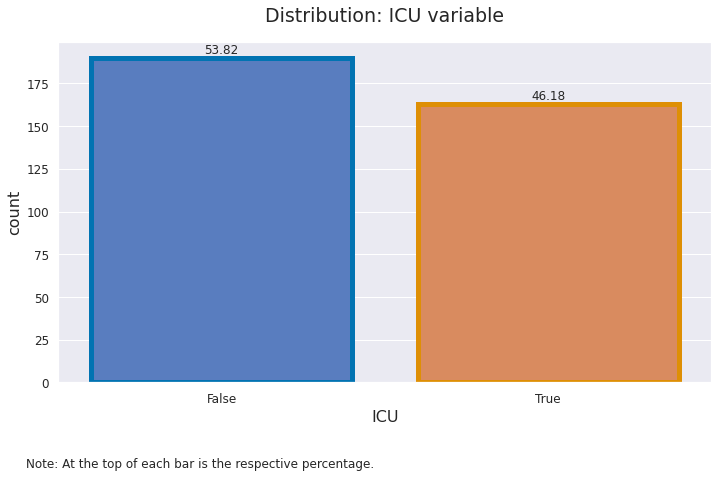

In [17]:
#plt.figure(figsize=(9,6))

ax = sns.countplot(x=patients_cleaned.query('WINDOW == "0-2"')['ICU'],
                   palette="muted",
                   linewidth=5,
                   edgecolor=sns.color_palette("colorblind"))

window_0_2_ICU = patients_cleaned.query('WINDOW == "0-2"')[['ICU']]
window_0_2_ICU_freq_table = create_freq_table(window_0_2_ICU, 'ICU')

add_labels_to_bars(ax, window_0_2_ICU_freq_table['percentage'], 2.6)

plt.title('Distribution: ICU variable', pad=20)
plt.xticks([0, 1],['False', 'True'])

ax.text(-0.6, -50, 'Note: At the top of each bar is the respective percentage.');

### <span style="color: yellow">>></span> Although we don't have a fifty-fifty distribution of the target, it has a good balance.

### Continuing the analysis... What about missing values?

## Understanding the missing values

In [18]:
patients_cleaned.isna().sum().values

array([  0,   0,   0,   0,   5,   5,   5,   5,   5,   5,   5,   5,   5,
       877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877,
       877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877,
       877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877,
       877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877,
       877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877,
       877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877,
       877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877,
       877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877,
       877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877,
       877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877,
       877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877,
       877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877,
       877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 87

In [19]:
columns_with_more_than_800_missing_values = \
    patients_cleaned.columns[ patients_cleaned.isna().sum() > 800 ].values

columns_with_more_than_800_missing_values

array(['ALBUMIN_MEDIAN', 'ALBUMIN_MEAN', 'ALBUMIN_MIN', 'ALBUMIN_MAX',
       'ALBUMIN_DIFF', 'BE_ARTERIAL_MEDIAN', 'BE_ARTERIAL_MEAN',
       'BE_ARTERIAL_MIN', 'BE_ARTERIAL_MAX', 'BE_ARTERIAL_DIFF',
       'BE_VENOUS_MEDIAN', 'BE_VENOUS_MEAN', 'BE_VENOUS_MIN',
       'BE_VENOUS_MAX', 'BE_VENOUS_DIFF', 'BIC_ARTERIAL_MEDIAN',
       'BIC_ARTERIAL_MEAN', 'BIC_ARTERIAL_MIN', 'BIC_ARTERIAL_MAX',
       'BIC_ARTERIAL_DIFF', 'BIC_VENOUS_MEDIAN', 'BIC_VENOUS_MEAN',
       'BIC_VENOUS_MIN', 'BIC_VENOUS_MAX', 'BIC_VENOUS_DIFF',
       'BILLIRUBIN_MEDIAN', 'BILLIRUBIN_MEAN', 'BILLIRUBIN_MIN',
       'BILLIRUBIN_MAX', 'BILLIRUBIN_DIFF', 'BLAST_MEDIAN', 'BLAST_MEAN',
       'BLAST_MIN', 'BLAST_MAX', 'BLAST_DIFF', 'CALCIUM_MEDIAN',
       'CALCIUM_MEAN', 'CALCIUM_MIN', 'CALCIUM_MAX', 'CALCIUM_DIFF',
       'CREATININ_MEDIAN', 'CREATININ_MEAN', 'CREATININ_MIN',
       'CREATININ_MAX', 'CREATININ_DIFF', 'FFA_MEDIAN', 'FFA_MEAN',
       'FFA_MIN', 'FFA_MAX', 'FFA_DIFF', 'GGT_MEDIAN', 'GGT_MEAN',
    

### <span style="color: yellow">>></span> We can see that the columns with missing values are those ones referring to exams... with MAX, MEAN, MIN, MEDIAN, DIFF values.

In [20]:
columns_with_more_than_800_missing_values_plus_id = \
    np.insert(columns_with_more_than_800_missing_values, 
              0, ['PATIENT_VISIT_IDENTIFIER'])

patients_cleaned[columns_with_more_than_800_missing_values_plus_id].head(17)

,PATIENT_VISIT_IDENTIFIER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,...,UREA_MEDIAN,UREA_MEAN,UREA_MIN,UREA_MAX,UREA_DIFF,DIMER_MEDIAN,DIMER_MEAN,DIMER_MIN,DIMER_MAX,DIMER_DIFF
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,...,-0.836145,-0.836145,-0.836145,-0.836145,-1.0,-0.994912,-0.994912,-0.994912,-0.994912,-1.0
3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,2,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,...,-0.836145,-0.836145,-0.836145,-0.836145,-1.0,-0.978029,-0.978029,-0.978029,-0.978029,-1.0
11,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Measurements obtained from tests such as blood, blood pressure and temperature, in addition to those we have in the dataset, do not usually increase rapidly over time, but gradually. It potentially presents vital signs and blood labs similar to neighboring windows [[1]](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19).

### <span style="color: red">>></span> Thinking about it, I decided to use the measurements obtained in the posterior or anterior windows of each patient to fill in the missing values.

## Dealing with missing data

Missing Data


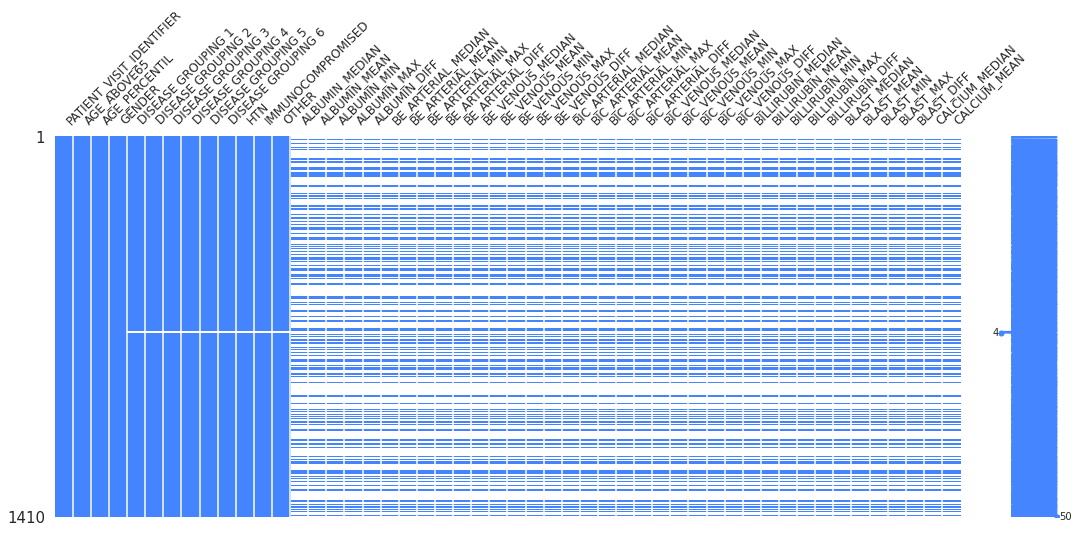

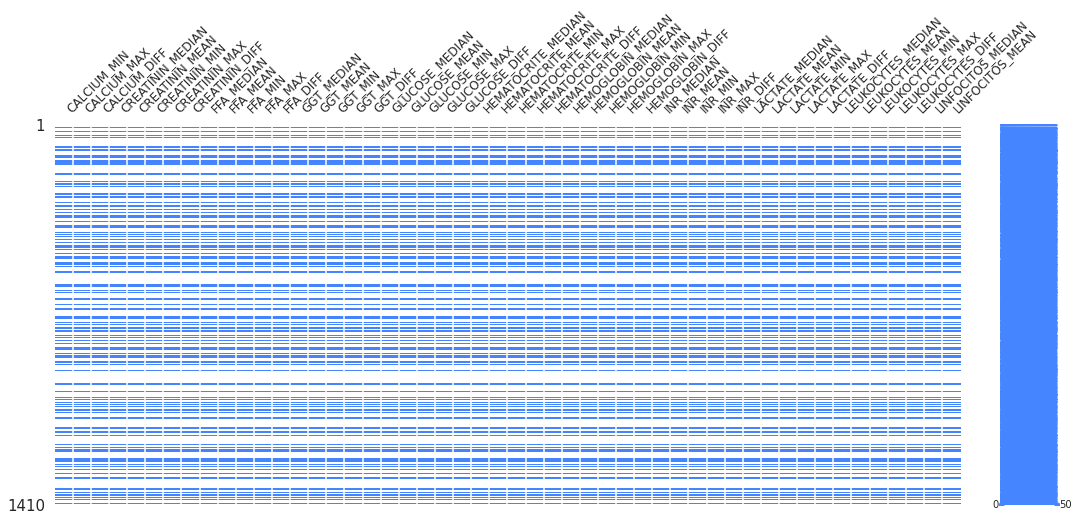

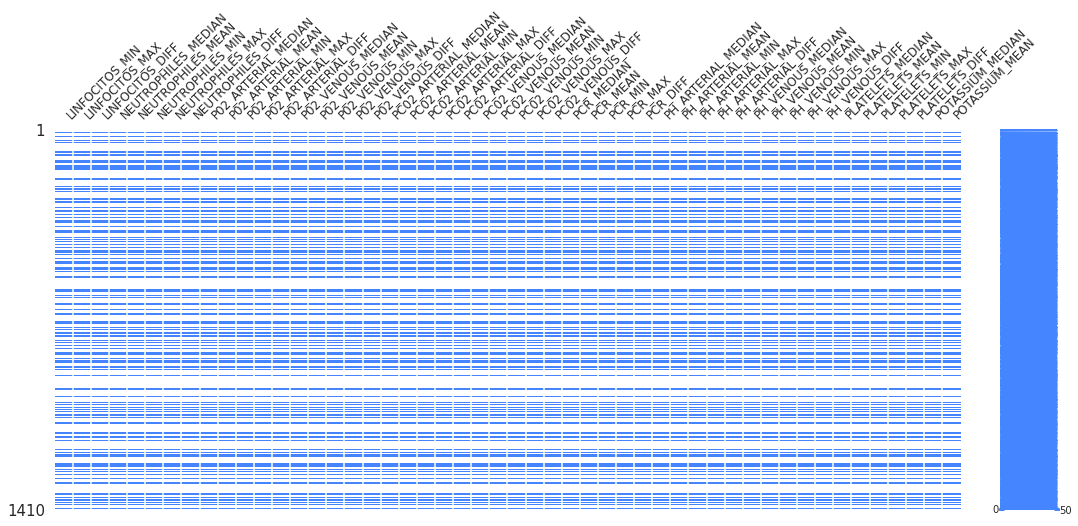

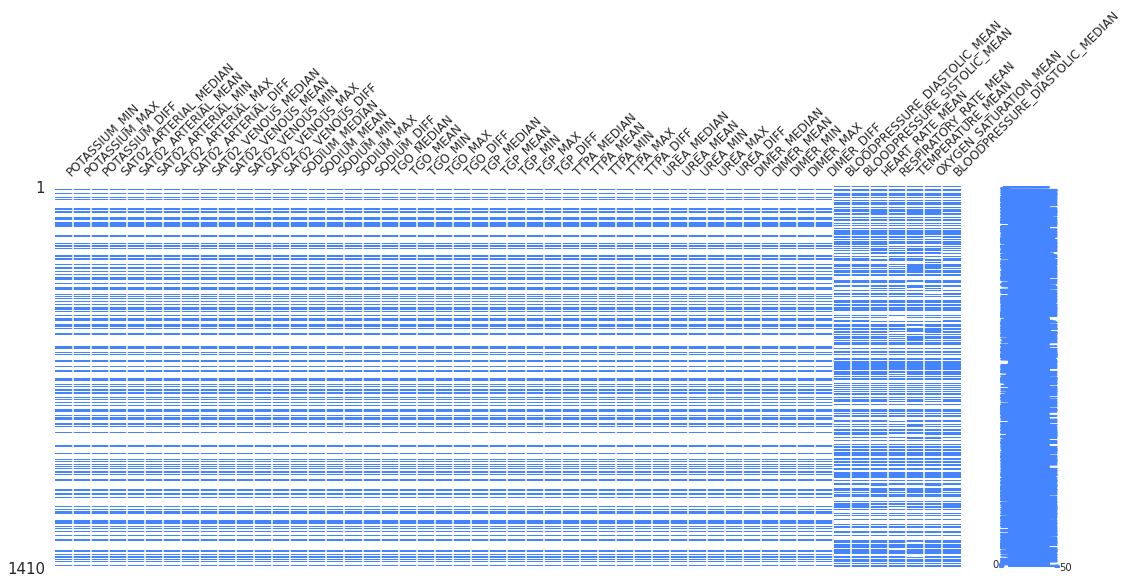

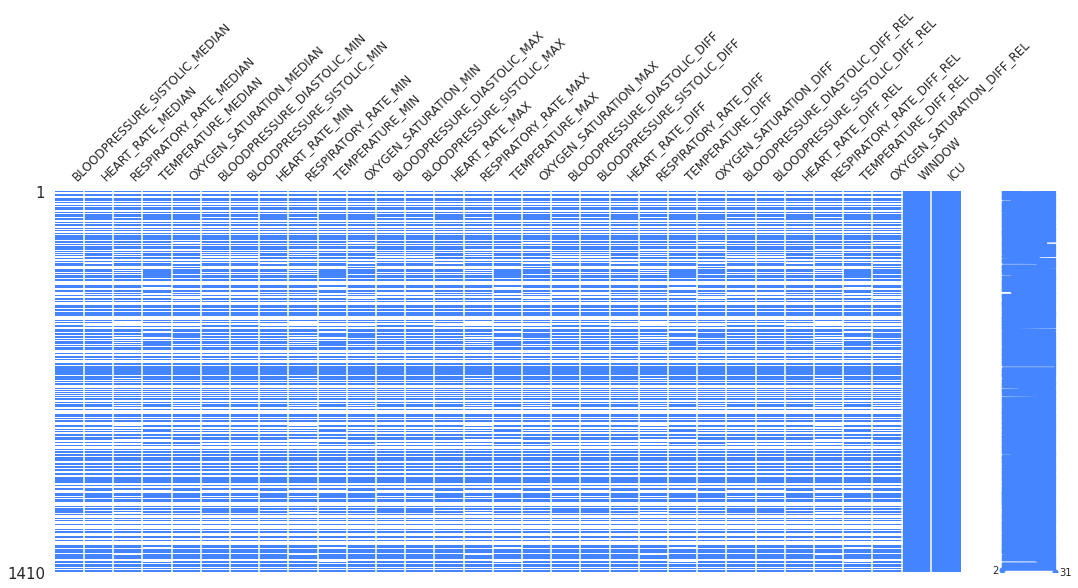

In [21]:
print('Missing Data')

for i in range(0, 231, 50):
    msno.matrix(patients_cleaned.iloc[:,i:i+50], 
                figsize=(18, 7), fontsize=12,
                color=(0.27, 0.52, 1.))

In [22]:
patients_cleaned_filled = fill_continuous_vars(patients_cleaned, 'bfill')
patients_cleaned_filled = fill_continuous_vars(patients_cleaned_filled, 'ffill')

In [23]:
patients_cleaned_filled.isna().sum().values

array([ 0,  0,  0,  0,  5,  5,  5,  5,  5,  5,  5,  5,  5,  0,  0, 33, 33,
       33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
       33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
       33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
       33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
       33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
       33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
       33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
       33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
       33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
       33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
       33, 33, 33, 33, 33, 33, 33, 33, 72, 72, 68, 87, 70, 67, 72, 72, 68,
       87, 70, 67, 72, 72, 68, 87, 70, 67, 72, 72, 68, 87, 70, 67, 72, 72,
       68, 87, 70, 67, 72

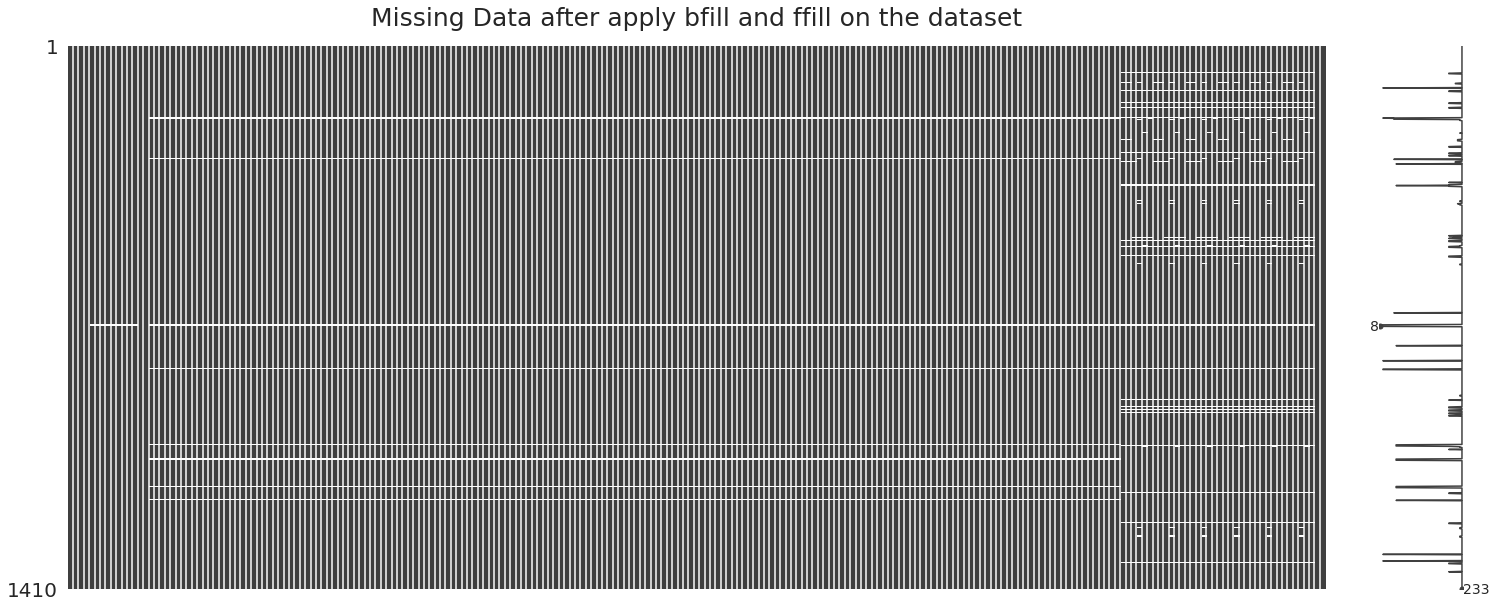

In [24]:
msno.matrix(patients_cleaned_filled)

plt.title('Missing Data after apply bfill and ffill on the dataset',
          fontsize=25, pad=20);

### <span style="color: yellow'">>></span> Even after the fill methods applied on the dataset, we still have NaN values. 

They represent the patients who don't have a record of exams result - excluding the exams taken when the patient was in the ICU.

### Let's drop them.

In [25]:
patients_no_missing_values = patients_cleaned_filled.dropna()

In [26]:
(patients_cleaned_filled['PATIENT_VISIT_IDENTIFIER'].nunique()
 - patients_no_missing_values['PATIENT_VISIT_IDENTIFIER'].nunique())

59

###  <span style="color: yellow'">>></span> 59 patients with NaN values in all exams were dropped from the dataset 

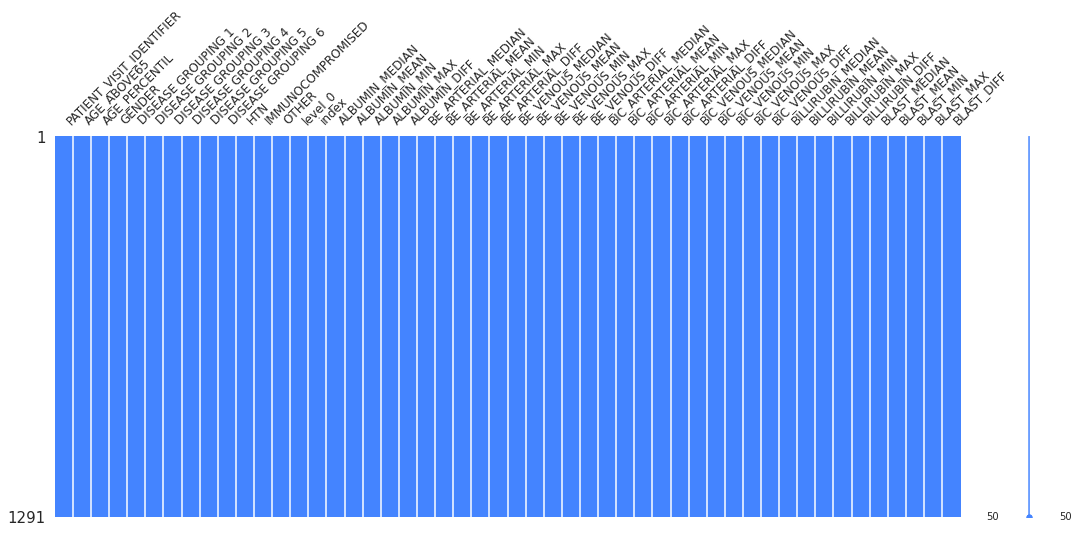

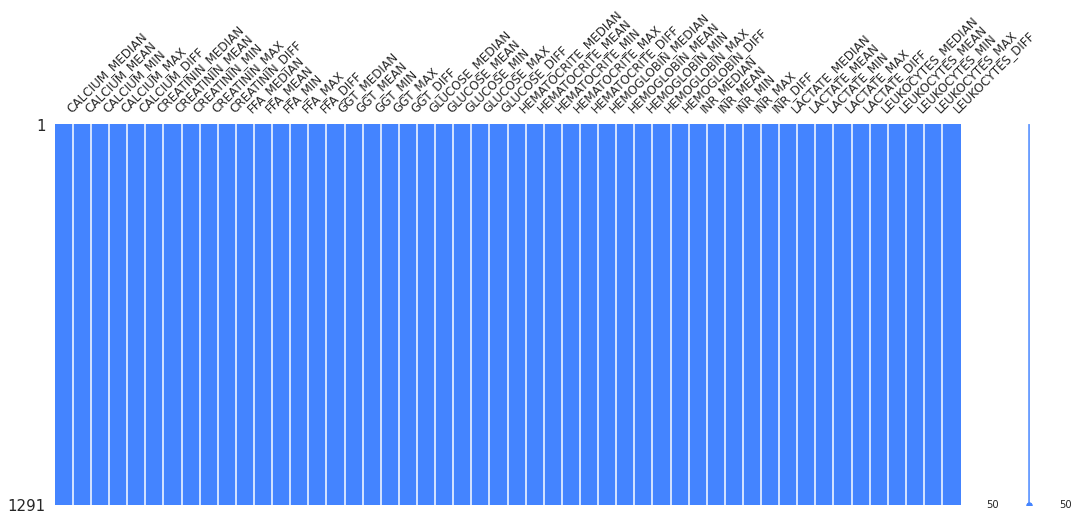

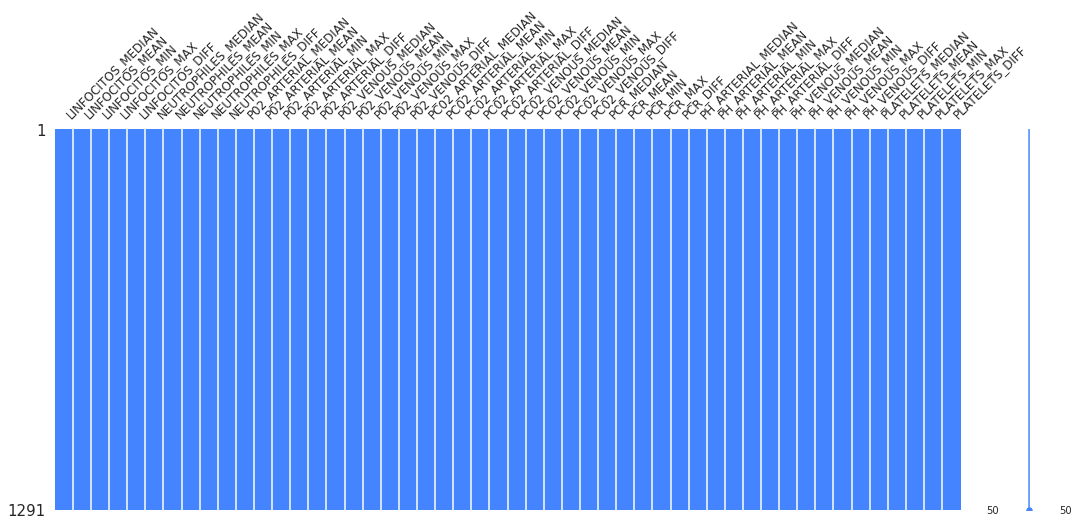

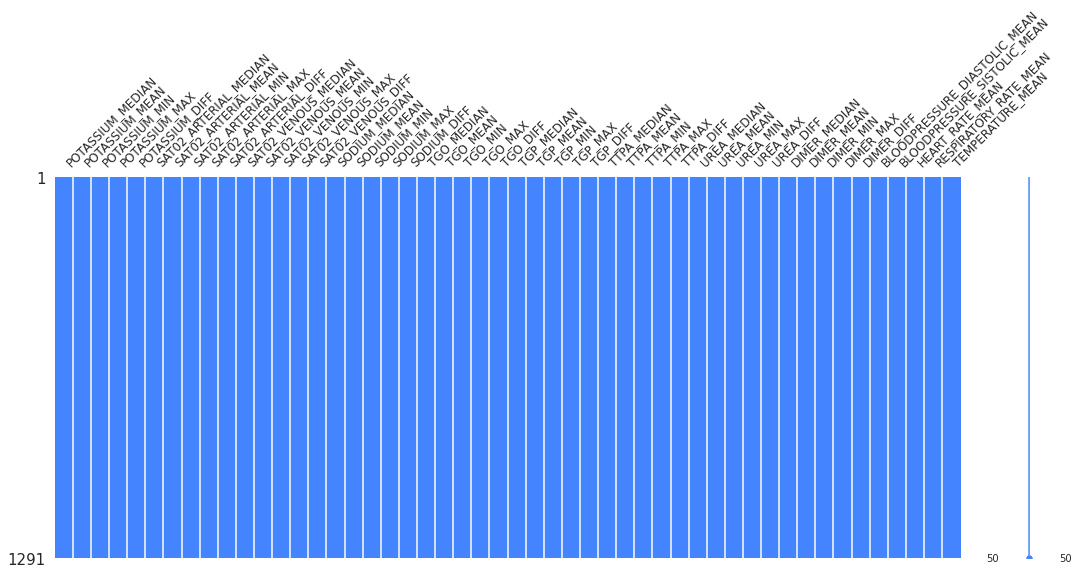

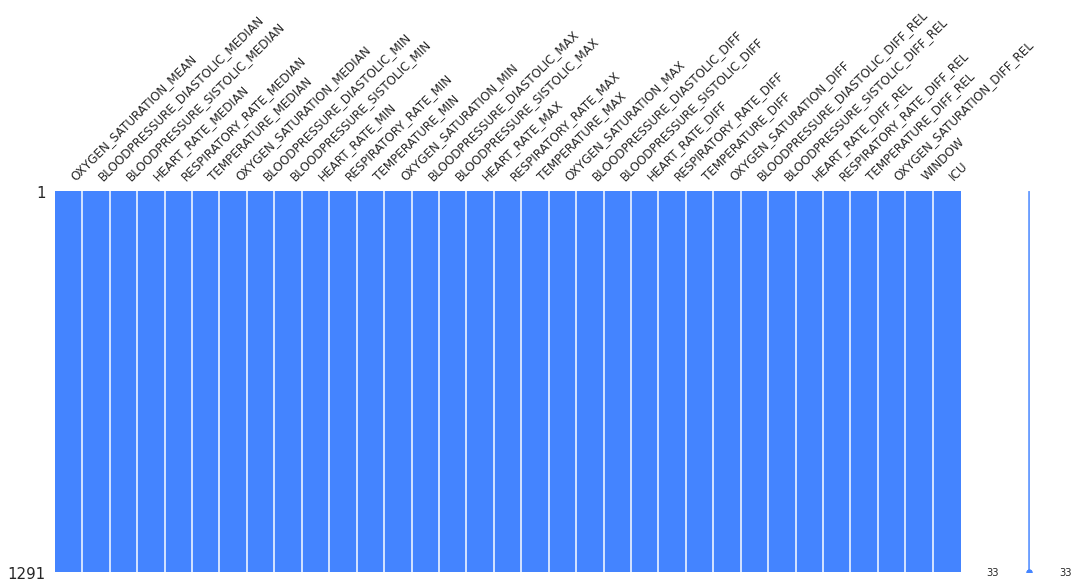

In [27]:
for i in range(0, 231, 50):
    msno.matrix(patients_no_missing_values.iloc[:,i:i+50], 
                figsize=(18, 7), fontsize=12,
                color=(0.27, 0.52, 1.));

In [28]:
patients_no_missing_values['PATIENT_VISIT_IDENTIFIER'].nunique()

294

### <span style="color: yellow">>></span> The columns now have no missing data!

### <span style="color: yellow">>></span> The dataset has 294 patients.

---

### Next step: decide which window will be used to train the machine learning model.

We need to decide on which window to train the model. As we signal whether a patient went to UCI or not, in all windows, we now need to choose which window to use.

The sooner we know whether a patient will go to the UCI or not, it will be better for the Hospital to prepare resources and start earlier an intensive care, if necessary.

### <span style="color: red">>></span> Then, thinking on it, I chose `WINDOW equals 0-2` to train the model because, in this way, we have in the first window the first exams values, and we will be able to do a prediction on future of a patient's situation.

## Selecting data to train the model

In [29]:
patients_cleaned_window_0_2 = patients_no_missing_values \
                                [patients_no_missing_values.WINDOW == '0-2'] \
                                .copy() \
                                .reset_index(drop=True)

patients_cleaned_window_0_2.drop('WINDOW', axis=1, inplace=True)

patients_cleaned_window_0_2

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1
1,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,1
2,3,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0
3,4,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.882353,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0
4,5,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-0.976190,-0.979798,-0.860870,-0.714460,-0.986481,-1.000000,-0.975891,-0.980129,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,380,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1
290,381,1,Above 90th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-0.619048,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.612627,-1.000000,0
291,382,0,50th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1
292,383,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0


### Now we have all the data cleaned. Then, let's do a brief exploratory analysis to see some distributions.

We can do that using `Pandas Profiling` library.


## Exploratory data analysis on the cleaned data

In [30]:
# profile = ProfileReport(patients_cleaned_window_0_2, minimal=True,
#                         title='Exploratory Data Analysis on Covid-19 Patients')

# profile.to_file('sirio_libanes_report.html')

### <span style="color: yellow'">>></span> Throught the report we can see that:

- Report Warnings:
    - 35 variables are constant - all of them represent the DIFF values.
    - Others 3 are unique: `PATIENT_VISIT_IDENTIFIER`, `level_0`, and `df_index`.
    - And we also have 10 variables with 0 in 1% to 9.5% of the dataset - depending on the variable. 
    
    
- Report Overview: 
    - **155 variables are numeric and 77 are categorical**.
    - The dataset has a total of **232 variables and 294 observations**, as we checked before.
    

### I noticed that `AGE_PERCENTIL` variable is an object.

### <span style="color: red">>></span> I'll convert it into an integer.

In [31]:
patients_cleaned_window_0_2[['AGE_PERCENTIL']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   AGE_PERCENTIL  294 non-null    object
dtypes: object(1)
memory usage: 2.4+ KB


In [32]:
patients_cleaned_window_0_2['AGE_PERCENTIL'].unique()

array(['60th', '10th', '40th', '70th', '20th', '50th', '80th', '30th',
       '90th', 'Above 90th'], dtype=object)

In [33]:
enc = OrdinalEncoder()

patients_cleaned_window_0_2['AGE_PERCENTIL'] = \
    enc.fit_transform(patients_cleaned_window_0_2[['AGE_PERCENTIL']])

In [34]:
patients_cleaned_window_0_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Columns: 232 entries, PATIENT_VISIT_IDENTIFIER to ICU
dtypes: float64(226), int64(6)
memory usage: 533.0 KB


### Now we have all the data with floats and integers.

---

### More detailed graphs:

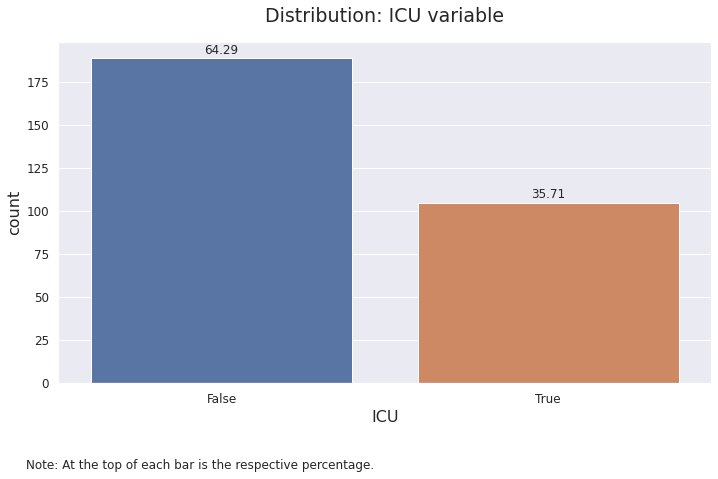

In [35]:
ax = sns.countplot(x=patients_cleaned_window_0_2['ICU'])

window_0_2_ICU_freq_table = create_freq_table(patients_cleaned_window_0_2, 'ICU')

add_labels_to_bars(ax, window_0_2_ICU_freq_table['percentage'], 2.6)

plt.title('Distribution: ICU variable', pad=20)
plt.xticks([0, 1],['False', 'True'])

ax.text(-0.6, -50, 'Note: At the top of each bar is the respective percentage.');

### We don't have a good balance as before the cleaning. Now more than half of patients didn't go to the UCI.

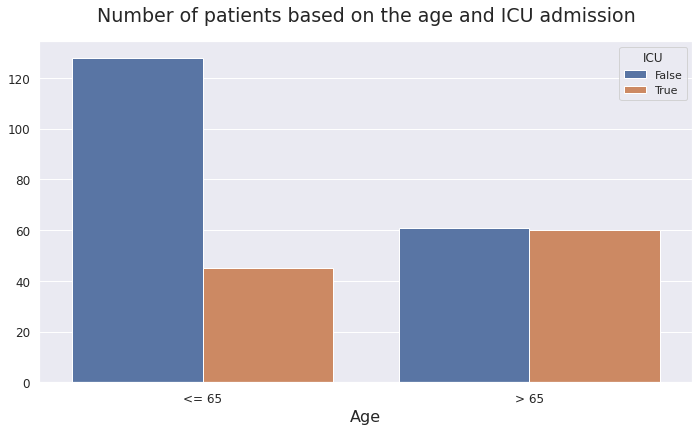

In [36]:
ax = sns.countplot(x='AGE_ABOVE65',
                   hue='ICU',
                   data=patients_cleaned_window_0_2)
              
plt.xticks([0, 1],['<= 65', '> 65'])
plt.xlabel('Age')

plt.ylabel('')
ax.legend(title='ICU', labels=['False', 'True'])

plt.title('Number of patients based on the age and ICU admission', pad=20);

### Age vs ICU:
    - Most of the patients are 65 years old or less.
    - However, most of ICU patients are more than 65.

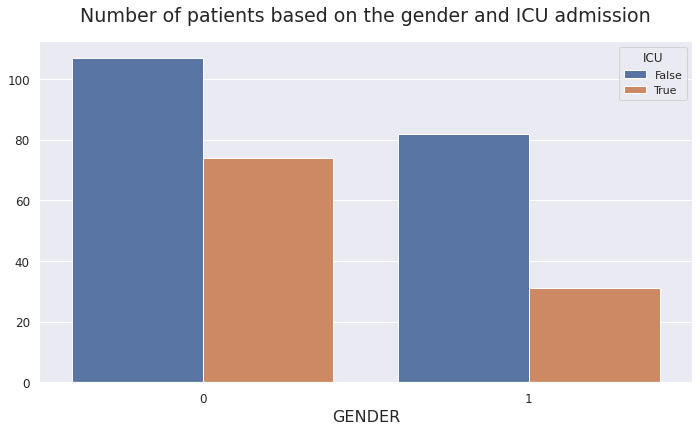

In [37]:
ax = sns.countplot(x='GENDER',
                   hue='ICU',
                   data=patients_cleaned_window_0_2)
              
plt.xlabel('GENDER')

plt.ylabel('')
ax.legend(title='ICU', labels=['False', 'True'])

plt.title('Number of patients based on the gender and ICU admission', pad=20);

### Gender vs ICU:
    - Because the dataset is anonymous, we don't have the information about the meaning of the values that each gender represents.
    - But we can conclude that gender 0 is predominant between the patients and the ICU admission.
---

## Feature Engineering

Sirio Libanes' team suggested adding three new features they consider be relevant from the biological point of view, they are `BLOODPRESSURE_ARTERIAL_MEAN`, `NEUTROPHILES/LINFOCITOS`, and `GASO`.

The function for creating these features can be found in the [Functions](#3.-Functions-used) section.

In [38]:
patients_cleaned_window_0_2_added_features = \
    add_new_features(patients_cleaned_window_0_2)

patients_cleaned_window_0_2_added_features.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU,BLOODPRESSURE_ARTERIAL_MEAN,NEUTROPHILES/LINFOCITOS,GASO
0,0,1,5.0,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1,-0.019310,0.949515,1
1,2,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,1,-0.554965,0.454450,1
2,3,0,3.0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0,-0.114846,0.938541,1
3,4,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0,0.170940,1.267746,1
4,5,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.860870,-0.714460,-0.986481,-1.000000,-0.975891,-0.980129,0,-0.204179,2.487410,1


### After cleaning the rows and creating new colums, we will now work on feature selection.


## Feature Selection

At begining, in the [Available Data](#Available-data-[1]) information, we saw that **some features expanded to the mean, median, max, min, diff and relative diff**.

**Should we work with all them or not?**

Works with all features expanded can causes a **multi-collinearity issue**. _Multi-collinearity_ means to have two or more independent variables in the data that are revealed to be closely related to each other. And, it can be a problem because it becomes difficult to isolate the individual effects of explanatory variables on the response variable. In other words, it impacts in the interpretability of the model [[2]](https://towardsdatascience.com/handling-multi-collinearity-6579eb99fd81). 

So, to deal with that I'll create some scenarios with differents feature subsets and then I'll test them to see what will be the best set for traning a model.

The reduction of the number of features by removing multicollinearity will also help with **big p, little n** problem presented in the dataset. The _big p, little n_ is when the dataset has much more predictors or "p" than samples or "n" in the dataset, when in fact, machine learnings assume that the number of predictors (p) will be smaller than the number of samples (n) [[3]](https://machinelearningmastery.com/how-to-handle-big-p-little-n-p-n-in-machine-learning/).

But before we deal with all this, let's check if there are some useless features, such as the `index`.

### Looking and removing useless features:

In [39]:
patients_cleaned_window_0_2_added_features.shape

(294, 235)

In [40]:
patients_cleaned_window_0_2_added_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Columns: 235 entries, PATIENT_VISIT_IDENTIFIER to GASO
dtypes: float64(228), int64(7)
memory usage: 539.9 KB


In [41]:
patients_cleaned_window_0_2_added_features \
    .select_dtypes(include='float64') \
    .columns

Index(['AGE_PERCENTIL', 'DISEASE GROUPING 1', 'DISEASE GROUPING 2',
       'DISEASE GROUPING 3', 'DISEASE GROUPING 4', 'DISEASE GROUPING 5',
       'DISEASE GROUPING 6', 'HTN', 'IMMUNOCOMPROMISED', 'OTHER',
       ...
       'TEMPERATURE_DIFF', 'OXYGEN_SATURATION_DIFF',
       'BLOODPRESSURE_DIASTOLIC_DIFF_REL', 'BLOODPRESSURE_SISTOLIC_DIFF_REL',
       'HEART_RATE_DIFF_REL', 'RESPIRATORY_RATE_DIFF_REL',
       'TEMPERATURE_DIFF_REL', 'OXYGEN_SATURATION_DIFF_REL',
       'BLOODPRESSURE_ARTERIAL_MEAN', 'NEUTROPHILES/LINFOCITOS'],
      dtype='object', length=228)

In [42]:
patients_cleaned_window_0_2_added_features \
    .select_dtypes(include='int64') \
    .columns

Index(['PATIENT_VISIT_IDENTIFIER', 'AGE_ABOVE65', 'GENDER', 'level_0', 'index',
       'ICU', 'GASO'],
      dtype='object')

In [43]:
patients_cleaned_window_0_2_added_features['level_0']

0         0
1         4
2         8
3        13
4        18
       ... 
289    1387
290    1391
291    1396
292    1400
293    1405
Name: level_0, Length: 294, dtype: int64

In [44]:
patients_cleaned_window_0_2_added_features['index']

0         0
1        10
2        15
3        20
4        25
       ... 
289    1900
290    1905
291    1910
292    1915
293    1920
Name: index, Length: 294, dtype: int64

<span style="color: red">>></span> As `PATIENT_VISIT_IDENTIFIER` does not help the ML, let's remove it. We can also do it with `index` and `level_0` feature that were created during the cleaning process.

- Removing useless features

In [45]:
patients_feature_selection = \
    patients_cleaned_window_0_2_added_features.drop(['PATIENT_VISIT_IDENTIFIER',
                                                     'index', 'level_0'], axis=1)

### Scenario 1: All features are included.
Training models with all features. Don't interfere in deciding which one to use or not to use in training.

Why I decided to keep this scenario if we saw that _multi-collinearity_ and _big p, little n_ are two problems presented in this dataset? Because, I'll apply another technique for this sample, called Recursive Feature Elimination (RFE). I explain about it later.

In [46]:
patients_features_scenario_1 = \
    patients_feature_selection.copy()

In [47]:
patients_features_scenario_1.shape

(294, 232)

### Scenario 2: Multi-collinearity: Remove independent features with high correlation between them.

- 2.1: On `Blood Exams` and `Vital Signs` expanded features select one for each exam or sign with the best correlation with the target.

    In addition to demographic information and previous grouped diseases, select only one of the features expanded (mean, median, max, min, diff and relative diff) for each blood exams and vital signs - choose that one with the highest correlation between it and the target.


- 2.2: After that, check if there are still independents features with a high correlation between them.
    
    Remove the independent features that still have a collinearity above 0.95, that means independent features with correlation between them above 0.95.

#### 2.1 Getting the all Blood Exams and Vital Signs features with the highest correlation with the target

Which one is the best? mean, median, max, min, diff or relative diff values?

In [48]:
blood_exams_and_vital_signs_columns = []
demographic_information_and_diseases_columns = []

for column in patients_feature_selection.columns:
    if (('_MEAN' in column) | 
        ('_MEDIAN' in column) |
        ('_MAX' in column) |
        ('_MIN' in column) |
        ('_DIFF' in column)):
        blood_exams_and_vital_signs_columns.append(column)
    else:
        demographic_information_and_diseases_columns.append(column)

# blood_exams_and_vital_signs

In [49]:
# getting the correlation of exams with ICU variable

blood_exams_and_vital_signs_columns_plus_ICU = \
    blood_exams_and_vital_signs_columns + ['ICU']

blood_exams_and_vital_signs_plus_ICU_corr = \
    (patients_feature_selection
        [blood_exams_and_vital_signs_columns_plus_ICU]
        .corr()
        ['ICU'])

In [50]:
# getting the name of the exams - wihtout mean, median... words

blood_exams_and_vital_signs = \
    blood_exams_and_vital_signs_plus_ICU_corr \
        .index \
        .map(lambda x: x.replace('_MEAN', '') \
                        .replace('_MEDIAN', '') \
                        .replace('_MIN', '') \
                        .replace('_MAX', '') \
                        .replace('_DIFF_REL', '') \
                        .replace('_DIFF', '')) \
        .unique() \
        .to_list()

blood_exams_and_vital_signs.remove('ICU')

len(blood_exams_and_vital_signs)

43

In [51]:
exams_vital_signs_best_corr_ICU = []

for exam in blood_exams_and_vital_signs:
    best_corr = select_exam_vital_signs_best_corr_ICU(blood_exams_and_vital_signs_plus_ICU_corr,
                                                       exam)
    exams_vital_signs_best_corr_ICU.append(best_corr)
    
#exams_vital_signs_best_corr_ICU

In [52]:
features_scenario_2_1 = \
    (demographic_information_and_diseases_columns + 
     exams_vital_signs_best_corr_ICU)

#features_scenario_2_1

In [53]:
patients_features_scenario_2_1 = \
    patients_cleaned_window_0_2[features_scenario_2_1].copy()

In [54]:
patients_features_scenario_2_1.shape

(294, 58)

#### 2.2 Removing independent features with a high correlation (>=0.95) between them.

In [55]:
patients_features_scenario_2_1.head()

,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,TTPA_MEDIAN,UREA_MEDIAN,DIMER_MEDIAN,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_MIN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MIN,OXYGEN_SATURATION_DIFF_REL,BLOODPRESSURE_ARTERIAL_MEAN
0,1,5.0,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,-0.825613,-0.836145,-0.994912,-1.000000,-1.000000,-0.162393,-0.593220,0.208791,-1.000000,-0.019310
1,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.846633,-0.836145,-0.978029,-0.515528,-0.351328,-0.111111,-0.645951,0.604396,-0.961262,-0.554965
2,0,3.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.846633,-0.937349,-0.978029,-1.000000,-1.000000,-0.384615,-0.457627,0.208791,-1.000000,-0.114846
3,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.846633,-0.903614,-1.000000,-1.000000,-0.883669,0.196581,-0.593220,0.538462,-0.980333,0.170940
4,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.846633,-0.884337,-1.000000,-0.860870,-0.714460,-0.401709,-0.525424,0.252747,-0.980129,-0.204179


- I'll remove the categorical data to see the correlation between continuous variables in:
        .select_dtypes(exclude='int64') \
        .drop('AGE_PERCENTIL', axis=1) \

In [56]:
corr_matrix = \
    patients_features_scenario_2_1 \
        .select_dtypes(exclude='int64') \
        .drop('AGE_PERCENTIL', axis=1) \
        .corr() \
        .abs()

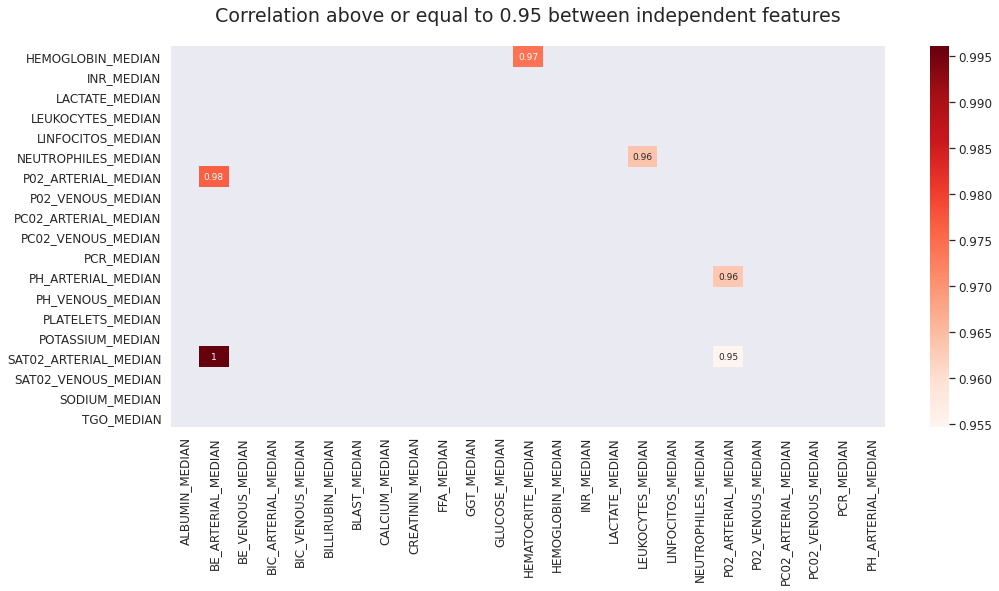

In [57]:
upper_triangle_without_main_diagonal = \
    np.triu(np.ones(corr_matrix.shape), k=1) \
      .astype(np.bool)

corr_matrix_upper_triangle = \
    corr_matrix.where(upper_triangle_without_main_diagonal)

filtered_corr_matrix = \
    corr_matrix_upper_triangle[(corr_matrix_upper_triangle >= .95)].T


plt.figure(figsize=(16,7))

sns.heatmap(filtered_corr_matrix.iloc[23:42, 10:35], 
            annot=True, cmap="Reds", annot_kws={"size":9})

plt.title('Correlation above or equal to 0.95 between independent features', 
          pad=25)
plt.show()

- Which features delete?


For the ones with 2 or more high correlation (multi-collinearity), delete them: `BE_ARTERIAL_MEDIAN`, `P02_ARTERIAL_MEDIAN`.

For the other ones, check the correlation between them and the ICU variable to decide which one has more impact in the ICU and choose them.

In [58]:
patients_features_scenario_2_2 = \
    patients_features_scenario_2_1 \
        .drop(['BE_ARTERIAL_MEDIAN', 'P02_ARTERIAL_MEDIAN'],
              axis=1)

In [59]:
features_correlation_above_95 = \
    X_features_with_high_correlation(patients_features_scenario_2_2, 0.95)

In [60]:
patients_features_scenario_2_1 \
    [features_correlation_above_95+['ICU']] \
    .corr() \
    ['ICU']

HEMATOCRITE_MEDIAN    -0.101614
HEMOGLOBIN_MEDIAN     -0.111067
LEUKOCYTES_MEDIAN      0.126396
NEUTROPHILES_MEDIAN    0.176143
ICU                    1.000000
Name: ICU, dtype: float64

Result: \
Between `LEUKOCYTES_MEDIAN` and `NEUTROPHILES_MEDIAN`: remove `LEUKOCYTES_MEDIAN` \
Between `HEMATOCRITE_MEDIAN` and `HEMOGLOBIN_MEDIAN`: remove `HEMATOCRITE_MEDIAN`

In [61]:
patients_features_scenario_2_2 = \
    patients_features_scenario_2_2 \
        .drop(['LEUKOCYTES_MEDIAN', 'HEMATOCRITE_MEDIAN'], 
              axis=1)

In [62]:
X_features_with_high_correlation(patients_features_scenario_2_2, 0.95)

[]

- In `patients_features_scenario_2_2` there are no more independent features with the correlation between them above or equal to 0.95.

In [63]:
patients_features_scenario_2_2.shape

(294, 54)

### Scenario 3: Use the features selected by Sírio Libanes team.

The features that make sense for determining the need for ICU, according to the Sirio-Libanes hospital team, are:
- "ICU",
- "WINDOW"<span style="color: red">*</span>,
- "PATIENT_VISIT_IDENTIFIER",
- "AGE_ABOVE65", 
- "GENDER", 
- "BLOODPRESSURE_ARTERIAL_MEAN", 
- "NEUTROPHILES/LINFOCITOS",
- "RESPIRATORY_RATE_MAX", 
- "HTN", 
- 'DISEASE GROUPING 1',
- 'DISEASE GROUPING 2',
- 'DISEASE GROUPING 3',
- 'DISEASE GROUPING 4',
- 'DISEASE GROUPING 5',
- 'DISEASE GROUPING 6',
- "GASO",
- "OXYGEN_SATURATION_MIN",
- "HEART_RATE_MAX",
- "PCR_MEAN",
- "CREATININ_MEAN"

So, I'll check this set of features and compare with the others sets.

<span style="color: red">*</span>Note: I removed `WINDOW` feature because the window is the same for all observations.

In [64]:
patients_features_scenario_3 = \
    sirio_libanes_feature_selection(patients_cleaned_window_0_2_added_features)

In [65]:
patients_features_scenario_3.shape

(294, 19)

### Scenario 6: Use Recursive Feature Elimination (RFE).

# 5. Machile Learning

Now, it's time to apply some machine learning models in each scenario created and then evaluate them.

For that, a function is created to run a model with the best selected hyperparameters and return the values of the metrics.\
Below you can see a little about the strategy used in this function, as well as the algorithms used and metrics chosen to compare them.

## Strategy

### Algorithms used
**<span style="color: red">>></span>** This is a binary classification problem. So, some of the algorithms I'll work on are:
- Gaussian Naive Bayes
- Logistic Regression
- Decision Tree
- Random Forest
- Dummy Regressor

### Cross-validation RepeatedStratifiedKFold
Cross-validation is a technique that is used to evaluate machine learning models on a limited data sample [[4]](https://machinelearningmastery.com/k-fold-cross-validation/). It's an alternative to train_test_split and make the use of the data for tranning and testing in a smart way. Let me explain it better.

When we are building a model for our machine learning problem, we often split our data into training and test sets. The first set we used to train our model, the model can learn from that subset. Then, we evaluate the model's performance with the validation/test set, which is the data the model has never seen before, and make predictions from that. In this way we have created a model.

The bad thing about a train_test_split is that we aren't sure how it was split, so it can create some bias and overfitting in the model. Besides that, when the data is small, keeping a portion for testing would decrease the accuracy of the predictive model [[5]](https://naadispeaks.wordpress.com/tag/train-test-split/).

But how cross-validation can solve the overfitting and bias problem? How does it use the data in a smart way to train and validate a model?

In fact, cross-validation uses the all the data as traning and test sets and it creates K models. See the figure below, an explanation on *K-fold cross-validation*:

![](https://upload.wikimedia.org/wikipedia/commons/b/b5/K-fold_cross_validation_EN.svg) 

It's a non-exhaustive type of cross-validation. The general procedure is as follows: [[4]](https://machinelearningmastery.com/k-fold-cross-validation/)

1. Shuffle the dataset randomly.
2. Split the dataset into k groups. For each unique group: \
    2.1 Take the group as a hold out or test data set \
    2.2 Take the remaining groups as a training data set \
    2.3 Fit a model on the training set and evaluate it on the test set \
    2.4 Retain the evaluation score and discard the model \
3. Summarize the skill of the model using the sample of model evaluation scores

Despite K-fold be the most known type of cross-validation, there are variations of it. And one of them fits our problem better: the **Repeated Stratified K-Fold**.

**<span style="color: red">>></span>** As we see before after all the cleaning our dataset becomes imbalanced - 64,29% went to the ICU and 35,71% not, see in [More Graphs section](#More-detailed-graphs:). Because of it, the Stratified K-Fold will be a better technique to use because it make sure that each fold is a good representative of the whole data [[6]](https://towardsdatascience.com/5-reasons-why-you-should-use-cross-validation-in-your-data-science-project-8163311a1e79). In other words, each fold contains approximately same percentage of samples of each target class [[7]](https://medium.com/@venkatasujit272/overview-of-cross-validation-3785d5414ece). And the Repeated Stratified K-Fold will repeat the Stratified K-Fold n times. It has the benefit of improving the estimate of the mean model performance since it will fit and evaluat many more models.


### Hyperparameters definition strategies
> A hyperparameter is a parameter whose value is used to control the learning process. By contrast, the values of other parameters (typically node weights) are derived via training. [[8]](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning))

There are some techniques to find the best hyperparamenters, two of them are Grid Search and Randomized Search. They are optimization algorithms which lets you select the best parameters for your model from a list or range of parameter options.

**GridSearchCV** or Exhaustive Grid Search "generates candidates from a grid of parameter values specified with the param_grid parameter" [[9]](https://scikit-learn.org/stable/modules/grid_search.html). It try all possible combinations of the parameter lists. So, if you have some situation like this:

```
                parameters_grid = {
                      "max_depth" : [3, 5],
                      "min_samples_split" : [32, 64, 128],
                      "min_samples_leaf" : [32, 64, 128],
                      "criterion" : ["gini", "entropy"]
                    }
```
It will try 2² * 3² = 36 possibilities.


**RandomizedSearchCV** "implements a randomized search over parameters, where each setting is sampled from a distribution over possible parameter values. This has two main benefits over an exhaustive search:" [[9]](https://scikit-learn.org/stable/modules/grid_search.html)
    1. A budget can be chosen independent of the number of parameters and possible values.
    2. Adding parameters that do not influence the performance does not decrease efficiency. 

So, in the same way, I can define a dictionary with the range or lists for each parameter, like this:
```
                parameters_randomized = {
                    "n_estimators" :randint(10, 101),
                    "max_depth" : randint(3, 6),
                    "min_samples_split" : randint(32, 129),
                    "min_samples_leaf" : randint(32, 129),
                    "bootstrap" : [True, False],
                    "criterion" : ["gini", "entropy"]
                }
```

Then it will select random combinations to train the model and score. The number of search iterations is set based on time/resources [[10]](https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search).

**<span style="color: red">>></span>** I chose to use RandomizedSearchCV because the benefits that it has over the GridSearchCV.

### Metrics to assess and evaluate the models
**<span style="color: red">>></span>** To assess and evaluate the models the metric used will be AUC (Area Under the ROC Curve) and Recall. --> However, the AUC scorer will be used to find the best parameters in the RandomizedSearchCV for refitting the estimator at the end. 

The AUC is useful for binary classification problem. It tells how much a model is capable of distinguishing between classes. It has a range of [0, 1]. The greater the value, the better is the performance of our model.

The Recall attempts to answer “What proportion of actual positives was identified correctly?”. As the defined problem deals with a question about whether the patient will need an ICU or not, it is important that we know if our model is predicting well for those who will need to enter the ICU. We'd better err by the excess of ICU beds instead of the lack of them.

## 5.1 Machine Learning Functions

In [66]:
def run_model_RandomizedSearchCV(model, data: pd.DataFrame, 
                                 n_splits: int, n_repeats: int, 
                                 search_parameters: dict, n_iter: int):
    
    np.random.seed(1231234)
    data = data.sample(frac=1).reset_index(drop=True)
    
    x_columns = data.columns
    x = data[x_columns].drop(['ICU'], axis=1)
    y = data['ICU']
    
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
    
    scoring = {'AUC': 'roc_auc', 'Recall': 'recall'}
    
    randomized_search_model = \
        RandomizedSearchCV(model, param_distributions=search_parameters,
                           n_iter=n_iter, cv=cv, scoring=scoring,
                           return_train_score=True, refit='AUC')
    
    randomized_search_model.fit(x, y)
    
    results = pd.DataFrame(randomized_search_model.cv_results_)
    
    best_results = results.iloc[randomized_search_model.best_index_]
    
    test_mean_auc = best_results['mean_test_AUC']
    training_mean_auc = best_results['mean_train_AUC']
    std_auc = best_results['std_test_AUC']
    
    test_mean_recall = best_results['mean_test_Recall']
    training_mean_recall = best_results['mean_train_Recall']
    std_recall = best_results['std_test_Recall']
    
    
    # print(f'AUC {test_mean_auc} - {training_mean_auc}')
    # print(results.iloc[randomized_search_model.best_index_])
    
    return randomized_search_model.best_params_, \
           test_mean_auc, training_mean_auc, \
           test_mean_recall, training_mean_recall


def run_all_models(model_and_grid: list, data: pd.DataFrame,
                   n_splits: int, n_repeats: int, n_iter: int) -> pd.DataFrame:
    
    all_models = pd.DataFrame(columns=['model', 'test_mean_AUC', 
                                       'training_mean_AUC',
                                       'test_mean_recall', 
                                       'training_mean_recall',
                                       'best_hyperparameters'])
    
    for model, param_grid in model_and_grid:

        best_hyperparameters, \
        test_mean_AUC, training_mean_AUC, \
        test_mean_recall, training_mean_recall = \
            run_model_RandomizedSearchCV(model, data, n_splits, 
                                         n_repeats, param_grid, n_iter)
        
        row = pd.Series([model.__class__.__name__, 
                         test_mean_AUC, training_mean_AUC,
                         test_mean_recall, training_mean_recall,
                         best_hyperparameters],
                        index=all_models.columns)
        
        all_models = all_models.append(row, ignore_index=True)
        
    return all_models.sort_values('test_mean_AUC', ascending=False)

In [67]:
def plot_roc_curve(model, data: pd.DataFrame, subtitle: str):

    np.random.seed(1231234)

    data = data.sample(frac=1).reset_index(drop=True)

    x_columns = data.columns
    x = data[x_columns].drop(['ICU'], axis=1)
    y = data['ICU']

    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)

    tprs = []
    aucs = []
    base_fpr = np.linspace(0, 1, 101)

    for i, (train_i, test_i) in enumerate(cv.split(x, y)):

        x_train, x_test = x.iloc[train_i], x.iloc[test_i]
        y_train, y_test = y.iloc[train_i], y.iloc[test_i]

        clf = model.fit(x_train, y_train)
        y_score = clf.predict_proba(x_test)

        fpr, tpr, _ = roc_curve(y_test, y_score[:,1])

        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)

        auc = roc_auc_score(y_test, y_score[:,1])
        aucs.append(auc)

    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)

    aucs = np.array(aucs)
    mean_auc = aucs.mean(axis=0)


    plt.plot(base_fpr, mean_tprs, 
             label= str(model.__class__.__name__)+' = %0.2f' % mean_auc)
    plt.legend(loc = 'lower right')

    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.plot([0,1], [0,1], linestyle='--', color='gray')

    plt.title('Receiver Operating Characteristic - ROC Curve\n'+subtitle, pad=20, fontsize=18)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

    # plt.show()

In [68]:
def return_best_models(best_params_all_models: pd.DataFrame):
    
    for index, row in best_params_all_models.iterrows():

        best_params = row['best_hyperparameters']
        
        
        if row['model'] == 'GradientBoostingClassifier':

            learning_rate = best_params['learning_rate']
            max_depth = best_params['max_depth']
            n_estimators = best_params['n_estimators']
            subsample = best_params['subsample']

            gb_model = GradientBoostingClassifier(learning_rate=learning_rate,
                                                  max_depth=max_depth,
                                                  n_estimators=n_estimators,
                                                  subsample=subsample)


        elif row['model'] == 'LogisticRegression':

            fit_intercept = best_params['fit_intercept']
            max_iter = best_params['max_iter']

            lr_model = LogisticRegression(fit_intercept=fit_intercept,
                                          max_iter=max_iter)


        elif row['model'] == 'DecisionTreeClassifier':

            criterion = best_params['criterion']
            max_depth = best_params['max_depth']
            min_samples_leaf = best_params['min_samples_leaf']
            splitter = best_params['splitter']

            dt_model = DecisionTreeClassifier(criterion=criterion,
                                             max_depth=max_depth,
                                             min_samples_leaf=min_samples_leaf,
                                             splitter=splitter)


        elif row['model'] == 'RandomForestClassifier':

            bootstrap = best_params['bootstrap']
            criterion = best_params['criterion']
            max_depth = best_params['max_depth']
            min_samples_leaf = best_params['min_samples_leaf']
            min_samples_split = best_params['min_samples_split']
            n_estimators = best_params['n_estimators']

            rf_model = RandomForestClassifier(bootstrap=bootstrap,
                                             criterion=criterion,
                                             max_depth=max_depth,
                                             min_samples_leaf=min_samples_leaf,
                                             min_samples_split=min_samples_split,
                                             n_estimators=n_estimators)


        elif row['model'] == 'DummyClassifier':

            strategy = best_params['strategy']

            dm_model = DummyClassifier(strategy=strategy)
    
    
    return [rf_model, gb_model, lr_model, dt_model, dm_model]

In [69]:
def plot_all_roc_curves(data: pd.DataFrame, models: list, subtitle: str):
    
        for model in models:
            
            plot_roc_curve(model, data, subtitle)  


#     model.fit(x_train, y_train)
#     proba = model.predict_proba(x_test)
#     fpr, tpr, _ = roc_curve(y_test, proba[:,1])
#     auc = roc_auc_score(y_test, proba[:,1])

#     plt.plot(fpr, tpr, label= str(model.__class__.__name__)+' = %0.2f' % auc)
#     plt.legend(loc = 'lower right')

In [94]:
def cv_confusion_matrix(model, data: pd.DataFrame):
    
    np.random.seed(1231234)

    data = data.sample(frac=1).reset_index(drop=True)

    x_columns = data.columns
    x = data[x_columns].drop(['ICU'], axis=1)
    y = data['ICU']

    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
  
    cv_iter = cv.split(x, y)
    cms = []

    for train, test in cv_iter:
        
        model.fit(x[train,], y[train])
        cm = confusion_matrix(y[test], model.predict(x[test]), labels=model.classes_)
        cms.append(cm)
        
    return np.mean(np.array(cms), axis=1)

In [70]:
def split_results_dataframe_metrics_hyperparms(results: pd.DataFrame):
    
    metrics = results.iloc[:,:5]
    best_hyperparameters = results.iloc[:,[0,5]].reset_index(drop=True)
    
    return metrics, best_hyperparameters

In [191]:
def plot_confusion_matrix(model, df: pd.DataFrame, scenario: str):

    np.random.seed(1231234)

    data = df.sample(frac=1).reset_index(drop=True)

    x_columns = data.columns
    x = data[x_columns].drop(['ICU'], axis=1)
    y = data['ICU']

    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)

    cms = []

    for i, (train_i, test_i) in enumerate(cv.split(x, y)):

        x_train, x_test = x.iloc[train_i], x.iloc[test_i]
        y_train, y_test = y.iloc[train_i], y.iloc[test_i]

        clf = model.fit(x_train, y_train)
        #tn, fp, fn, tp
        cm = confusion_matrix(y_test, clf.predict(x_test), labels=model.classes_).ravel()
        cms.append(cm)

    cms_array = np.array(cms)
    cms_mean_matrix = cms_array.mean(axis=0, dtype=int).reshape(2,2)

    print(cms_array.mean(axis=0, dtype=int))

    sns.heatmap(cms_mean_matrix, linewidth=0.5, annot=True, cbar=False)

    plt.title('Confusion Matrix\n'+model.__class__.__name__+' '+scenario, pad=20, fontsize=18)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

    #print(np.mean(np.array(cms)))
    #print (np.mean(np.array(cms), axis=1))

## 5.2 Creating useful variables

In [71]:
n_splits = 5
n_repeats = 10
n_iter = 10

In [72]:
gb_clf = GradientBoostingClassifier()
lr_clf = LogisticRegression()
dt_clf = DecisionTreeClassifier()
rf_clf = RandomForestClassifier()
dummy_clf = DummyClassifier()

In [73]:
gb_param_grid = {
    "learning_rate": uniform(),
    "subsample"    : uniform(),
    "n_estimators" : randint(10, 101),
    "max_depth"    : randint(4, 10)
} 

lr_param_grid = {
    "fit_intercept": [True, False],
    "max_iter"     : randint(100, 10000)
}

dt_param_grid = {
    "max_depth"       : randint(3, 25),
    "min_samples_leaf": randint(1, 9),
    "splitter"        : ['best', 'random'],
    "criterion"       : ["gini", "entropy"]   
}

rf_param_grid = {
    "n_estimators"     : randint(10, 101),
    "max_depth"        : randint(3, 6),
    "min_samples_split": randint(32, 129),
    "min_samples_leaf" : randint(32, 129),
    "bootstrap"        : [True, False],
    "criterion"        : ["gini", "entropy"]
}

dummy_param_grid = {
    "strategy" : ["stratified", "most_frequent", "prior", "uniform"]
}

In [74]:
model_and_grid = [(gb_clf, gb_param_grid),
                  (lr_clf, lr_param_grid),
                  (dt_clf, dt_param_grid),
                  (rf_clf, rf_param_grid),
                  (dummy_clf, dummy_param_grid)]

## 5.3 Running Machine Models for each Scenario 

### 5.3.1 Scenario 1: All features are included.

In [75]:
scenario_1_results = \
    run_all_models(model_and_grid, patients_features_scenario_1, 
                   n_splits, n_repeats, n_iter)

scenario_1_metrics_results, scenario_1_best_hyperparameters = \
    split_results_dataframe_metrics_hyperparms(scenario_1_results)

# scenario_1_results

/home/gabriela/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


In [76]:
scenario_1_metrics_results

,model,test_mean_AUC,training_mean_AUC,test_mean_recall,training_mean_recall
3,RandomForestClassifier,0.768047,0.857035,0.326667,0.456905
0,GradientBoostingClassifier,0.755830,1.000000,0.495238,1.000000
1,LogisticRegression,0.732134,0.861199,0.462857,0.605476
2,DecisionTreeClassifier,0.686210,0.930270,0.453333,0.723571
4,DummyClassifier,0.514968,0.505397,0.366667,0.357619


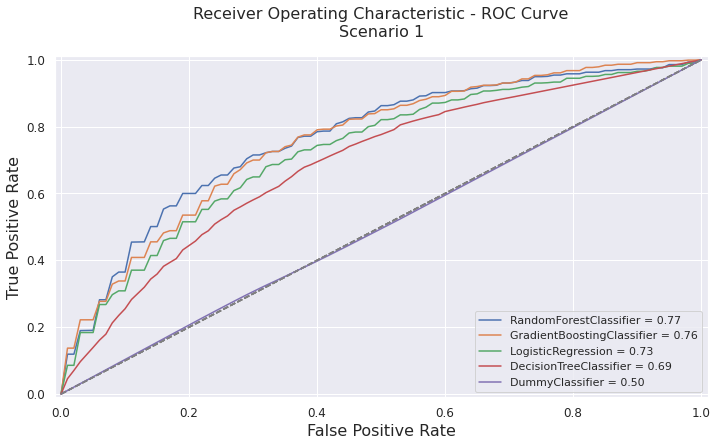

In [77]:
scenario_1_best_models = return_best_models(scenario_1_best_hyperparameters)

plot_all_roc_curves(data=patients_features_scenario_1,
                    models=scenario_1_best_models,
                    subtitle='Scenario 1')

### 5.3.2 Scenario 2.1: One statistic measure of each exam with the best correlation with the target.

In [78]:
scenario_2_1_results = \
    run_all_models(model_and_grid, patients_features_scenario_2_1, 
                   n_splits, n_repeats, n_iter)

scenario_2_1_metrics_results, scenario_2_1_best_hyperparameters = \
    split_results_dataframe_metrics_hyperparms(scenario_2_1_results)

# scenario_2_1_results

/home/gabriela/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


In [79]:
scenario_2_1_metrics_results

,model,test_mean_AUC,training_mean_AUC,test_mean_recall,training_mean_recall
3,RandomForestClassifier,0.778059,0.856536,0.240952,0.362381
0,GradientBoostingClassifier,0.756686,1.000000,0.494286,1.000000
1,LogisticRegression,0.748650,0.841361,0.426667,0.542857
2,DecisionTreeClassifier,0.693495,0.928573,0.465714,0.726667
4,DummyClassifier,0.514968,0.505397,0.366667,0.357619


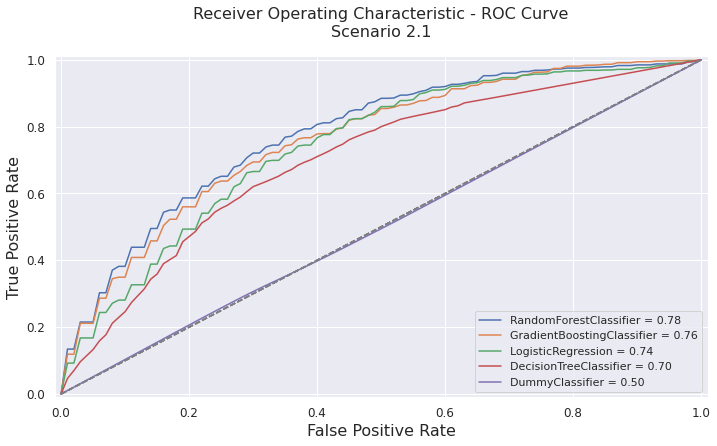

In [80]:
scenario_2_1_best_models = return_best_models(scenario_2_1_best_hyperparameters)

plot_all_roc_curves(data=patients_features_scenario_2_1,
                    models=scenario_2_1_best_models,
                    subtitle='Scenario 2.1')

### 5.3.3 Scenario 2.2: Features with high correlation (>=0.95) removed.

In [81]:
scenario_2_2_results = \
    run_all_models(model_and_grid, patients_features_scenario_2_2, 
                   n_splits, n_repeats, n_iter)

scenario_2_2_metrics_results, scenario_2_2_best_hyperparameters = \
    split_results_dataframe_metrics_hyperparms(scenario_2_2_results)

#scenario_2_2_results

/home/gabriela/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


In [82]:
scenario_2_2_metrics_results

,model,test_mean_AUC,training_mean_AUC,test_mean_recall,training_mean_recall
3,RandomForestClassifier,0.777152,0.855443,0.247619,0.374762
0,GradientBoostingClassifier,0.757918,1.000000,0.496190,1.000000
1,LogisticRegression,0.749147,0.840923,0.425714,0.543571
2,DecisionTreeClassifier,0.695763,0.928833,0.460952,0.723810
4,DummyClassifier,0.514968,0.505397,0.366667,0.357619


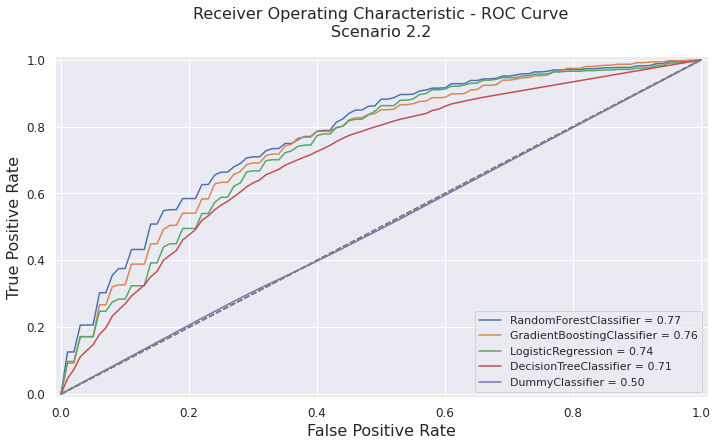

In [83]:
scenario_2_2_best_models = return_best_models(scenario_2_2_best_hyperparameters)

plot_all_roc_curves(data=patients_features_scenario_2_2,
                    models=scenario_2_2_best_models,
                    subtitle='Scenario 2.2')

### 5.3.4 Scenario 3: Features suggested by Sírio Libanes team.

In [84]:
scenario_3_results = \
    run_all_models(model_and_grid, patients_features_scenario_3, 
                   n_splits, n_repeats, n_iter)

scenario_3_metrics_results, scenario_3_best_hyperparameters = \
    split_results_dataframe_metrics_hyperparms(scenario_3_results)

/home/gabriela/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


In [85]:
scenario_3_metrics_results

,model,test_mean_AUC,training_mean_AUC,test_mean_recall,training_mean_recall
3,RandomForestClassifier,0.782514,0.835624,0.318095,0.393810
0,GradientBoostingClassifier,0.749180,1.000000,0.497143,1.000000
1,LogisticRegression,0.736978,0.796036,0.357143,0.429524
2,DecisionTreeClassifier,0.704363,0.912898,0.510476,0.713095
4,DummyClassifier,0.514968,0.505397,0.366667,0.357619


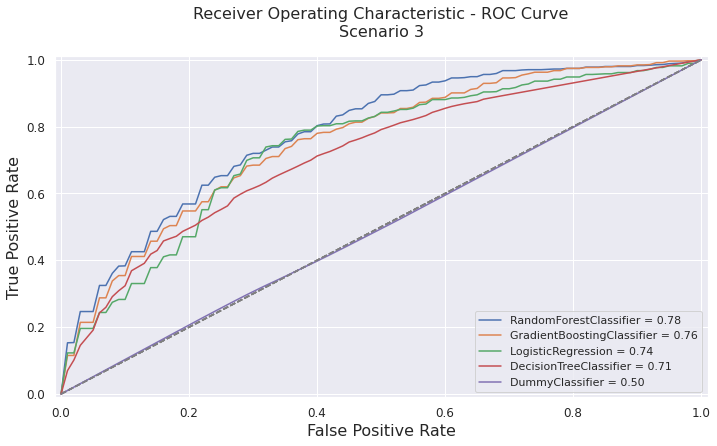

In [88]:
scenario_3_best_models = return_best_models(scenario_3_best_hyperparameters)

plot_all_roc_curves(data=patients_features_scenario_3,
                    models=scenario_3_best_models,
                    subtitle='Scenario 3')

## 5.4 Evaluating Models and Scenarios

**For all 4 scenarios, the Random Forest algorithm performed better**, followed by the Gradient Boosting algorithm. However, the best model generated was that of **scenario 3** - with the features suggested by the Sirio Libanes team, with 0.782 AUC for the test data. The model generated in scenario 2.1 was the second best in terms of AUC - 0.778, which was trained with a single statistical metric for all exams - the one chosen was the one most correlated with the target.

Regarding the **Gradient Boosting algorithm, being in the second position in all scenarios**, the best results were the models generated by **scenario 2.2**, in which the selected features were those with a correlation less than or equal to 0.95; and scenario 2.1. The AUC for these two cases was 0.757 and 0.756, respectively.

So, the rank for them is:
1. Random Forest - scenario 3 - AUC: 0.782
2. Random Forest - scenario 2.1 - AUC: 0.778
3. 
4. 
5. Gradient Boosting - scenario 2.2 - AUC: 0.757
6. Gradient Boosting - scenario 2.1 - AUC: 0.756

The models performed very closely. However, it was possible to notice some difference in the recall between the Random Forests and Gradient Boosting algorithms - the Gradient Boosting recall being superior. So, among the 4 selected, I chose the two best of the RF and the two best of the 2 GB.

From these 4 models I'll check the confusion matrix and compare the false negative rates.

In [188]:
selected_models_and_scenarios = \
    [(scenario_3_best_models[0], patients_features_scenario_3, "Scenario 3"), 
     (scenario_2_1_best_models[0], patients_features_scenario_2_1, "Scenario 2.1"),
     (scenario_2_2_best_models[1], patients_features_scenario_2_2, "Scenario 2.2"),
     (scenario_2_1_best_models[1], patients_features_scenario_2_1, "Scenario 2.1")]

[34  2 14  6]


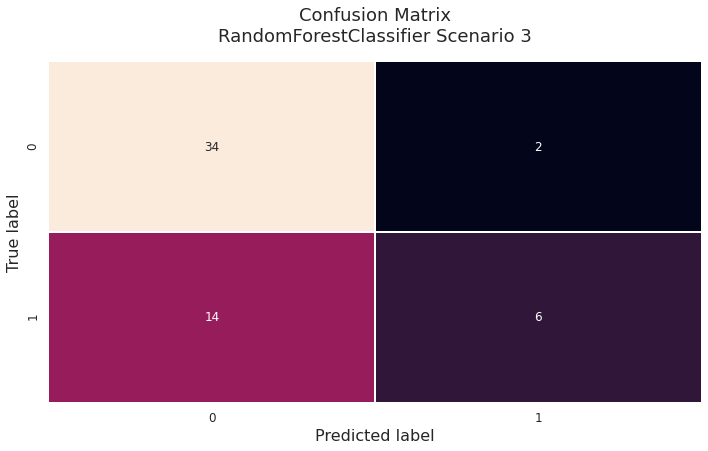

[35  2 15  5]


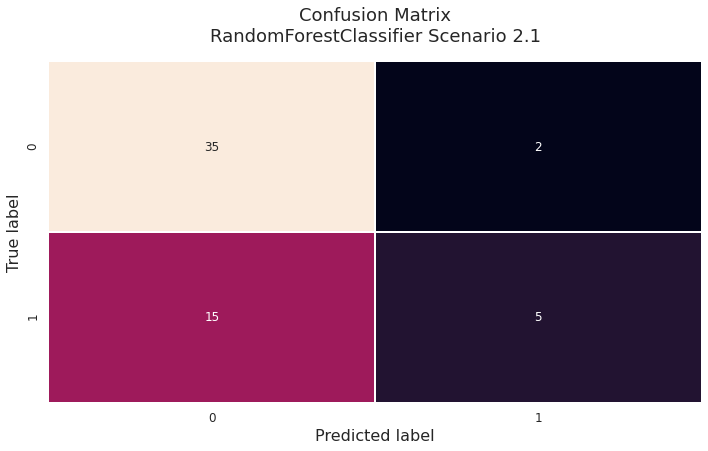

[31  6 10 10]


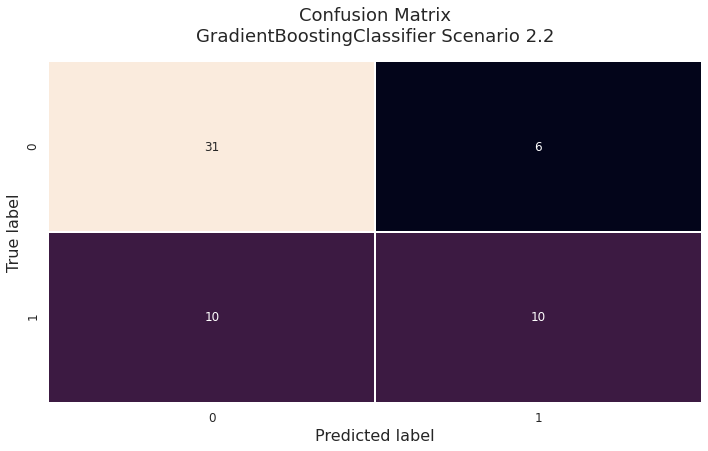

[31  6 10 10]


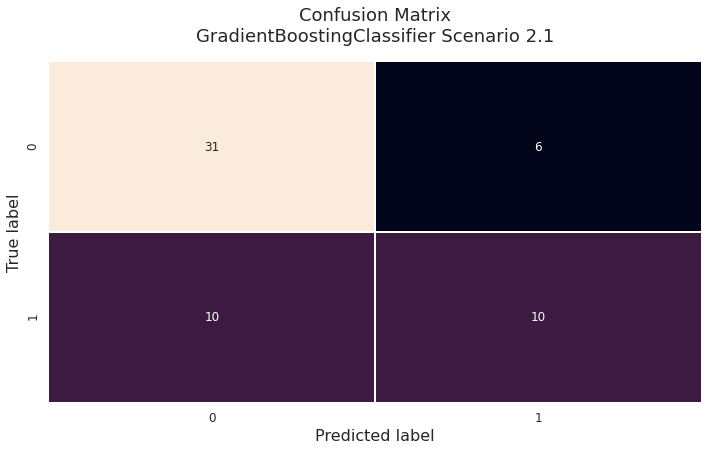

In [192]:
for model, scenario, title in selected_models_and_scenarios:
    plot_confusion_matrix(model, scenario, title)

In [ ]:
run_model_RandomizedSearchCV(rf_clf, patients_features_scenario_1,
                             n_splits, n_repeats, rf_param_grid, n_iter)